## **Customer Segmentation Clustering**

Name: Ryan Yeo

Admin Number: P2214452

Class: DAAA/FT/2A/01

<hr>

**Goal: To train a clustering model to be used for customer segmentation in order to try and generate profits through targeted advertisment for each customer segment**

## Background Research

Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. 

Segmentation allows marketers to better tailor their marketing efforts to various audience subsets. Those efforts can relate to both communications and product development. Customer segmentation helps a company with to:
- Create and communicate targeted marketing messages that will resonate with specific groups of customers
- Establish better customer relationships
- Focus on the most profitable customers
- Improve customer service

Customer segmentation requires a company to gather specific information about customers and analyze it to identify patterns that can be used to create segments. Common characteristics obtained from different customer segments can guide how a company markets to individual segments and what products or services it promotes to them. 

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.lines as lines

# SKLEARN Libraries

# Models
from sklearn.cluster import KMeans # Centroid-Based
from sklearn.cluster import AgglomerativeClustering # Hierarchical-Based
from sklearn.mixture import GaussianMixture # Distribution-Based
from sklearn.cluster import DBSCAN # Density-Based
from sklearn.cluster import AffinityPropagation  # Graph-Based
from sklearn.neighbors import NearestNeighbors


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, silhouette_samples, make_scorer, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV


In [2]:
# Ignore deprecated warnings
import warnings

# Ignore deprecated warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('Customer_Dataset.csv')
display(df.head())

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 1. EDA

In [4]:
print(list(df.columns))

['CustomerID', 'Gender', 'Age', 'Income (k$)', 'How Much They Spend']


Rename some columns

In [5]:
df.rename(columns={'Income (k$)' : 'Income', 'How Much They Spend' : 'Spending'}, inplace=True)
print(list(df.columns))

['CustomerID', 'Gender', 'Age', 'Income', 'Spending']


In [6]:
print(f"Shape: {df.shape}")
print(df.info())

Shape: (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  200 non-null    int64 
 1   Gender      200 non-null    object
 2   Age         200 non-null    int64 
 3   Income      200 non-null    int64 
 4   Spending    200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


**Data Dictionary**

| Column Name  | Data Type  | Definition  | 
|---|---|---|
| Customer ID  | Primary Key  | Unique Customer identifier ranging from 1 to 200  |
| Gender  | Nominal Category | Customer's gender  |
| Age  |  Numeric | Customer's Age  |
| Income  |  Numeric | Monthly amount the customer Earns in $1000  |
| Spending  | Numeric  |  Spending score ranging from 0-100 where the higher the score, the more they spend |

In [7]:
print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
display(df.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS


,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


Drop unecessary columns

In [8]:
df.drop('CustomerID', axis=1, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Gender    200 non-null    object
 1   Age       200 non-null    int64 
 2   Income    200 non-null    int64 
 3   Spending  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB
None


Convert columns to category

In [9]:
# Convert columns to category
df[['Gender']] = df[['Gender']].apply(lambda x: x.astype('category'))

Check all unique values in categorical features

In [10]:
print(f"Gender: {list(df['Gender'].unique())}")

Gender: ['Male', 'Female']


Check for missing values

In [11]:
print(df.isnull().sum())

Gender      0
Age         0
Income      0
Spending    0
dtype: int64


To prevent the mutation of our original dataset, we will make a copy of it for our EDA

In [12]:
df_eda = df.copy()

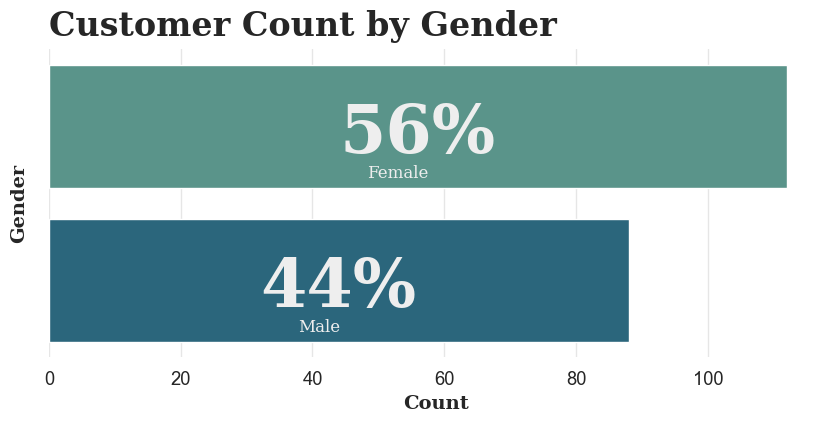

In [13]:
# Edit seaborn style
plt.figure(figsize=(10, 4))
sns.set_context('notebook', font_scale=1.2)
# Set grid color 
sns.set_style('whitegrid', {'grid.color': '0.9'})
# Remove the frame
plt.box(False)


# Plot bar plot
sns.countplot(y=df_eda['Gender'], palette="crest")

# Get actual numbers to annotate the plot
female = df_eda['Gender'].value_counts()['Female']
male = df_eda['Gender'].value_counts()['Male']

# Annotations
plt.annotate(f"{int((male/(female+male))*100)}%", xy=(male//2, 1.05), va='center', ha='center', fontsize=48, fontweight='bold', fontfamily='serif', color='#eeeeee')
plt.annotate(f"Male", xy = (male//2-3, 1.3), va='center', ha='center', fontsize=12, fontweight='light', fontfamily='serif', color='#eeeeee')

plt.annotate(f"{int((female/(female+male))*100)}%", xy=(female//2, 0.05), va='center', ha='center', fontsize=48, fontweight='bold', fontfamily='serif', color='#eeeeee')
plt.annotate(f"Female", xy = (female//2-3, 0.3), va='center', ha='center', fontsize=12, fontweight='light', fontfamily='serif', color='#eeeeee')


# Set labels
plt.xlabel('Count', fontsize=14, fontweight='bold', fontfamily='serif')
plt.ylabel('Gender', fontsize=14, fontweight='bold', fontfamily='serif', labelpad=15)
# Remove ticks
plt.yticks([])

# Set title
plt.title('Customer Count by Gender', fontsize=24, fontweight='bold', fontfamily='serif', loc='left', pad=10)

plt.show()

Observations:
From the graph, we see a fairly even split with slightly more females than males

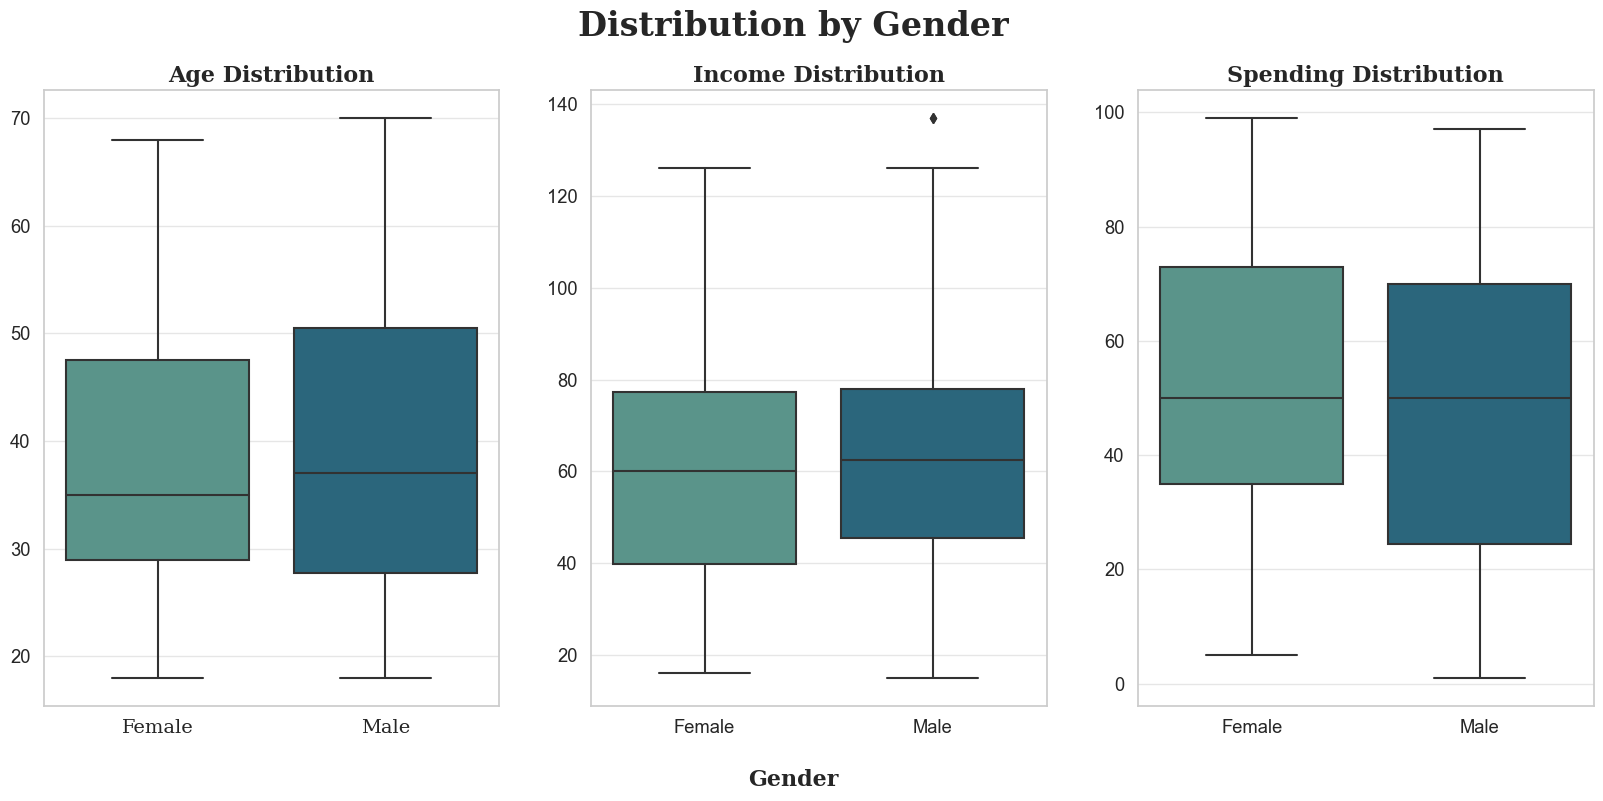

In [14]:
# Compare the distribution of Spending and Annual Income by Gender
fig, axs = plt.subplots(1, 3, figsize=(20,8))
sns.set_context('notebook', font_scale=1.2)

# Set title
fig.suptitle('Distribution by Gender', fontsize=24, fontweight='bold', fontfamily='serif')

# Age
sns.boxplot(ax=axs[0], data=df_eda, x='Gender', y='Age', palette='crest', orient='v')
axs[0].set_title('Age Distribution', fontsize=16, fontweight='bold', fontfamily='serif')
axs[0].set_xlabel('')
axs[0].set_xticklabels(['Female', 'Male'], fontfamily='serif', fontsize=14)
axs[0].set_ylabel('')

# Income
sns.boxplot(ax=axs[1], data=df_eda, x='Gender', y='Income', palette='crest', orient='v')
axs[1].set_title('Income Distribution', fontsize=16, fontweight='bold', fontfamily='serif')
axs[1].set_xlabel('')
axs[0].set_xticklabels(['Female', 'Male'], fontfamily='serif', fontsize=14)
axs[1].set_ylabel('')

# Spending
sns.boxplot(ax=axs[2], data=df_eda, x='Gender', y='Spending', palette='crest', orient='v')
axs[2].set_title('Spending Distribution', fontsize=16, fontweight='bold', fontfamily='serif')
axs[2].set_xlabel('')
axs[0].set_xticklabels(['Female', 'Male'], fontfamily='serif', fontsize=14)
axs[2].set_ylabel('')

fig.text(0.5, 0.01, 'Gender', fontsize=16, fontweight='bold', fontfamily='serif', ha='center')




plt.show()



**Observations**:
- From the graph, it seems that Age, Income and Spending are quite normally distributed with very few outliers
- In general, it seems that the distribution between the two genders do not differ much

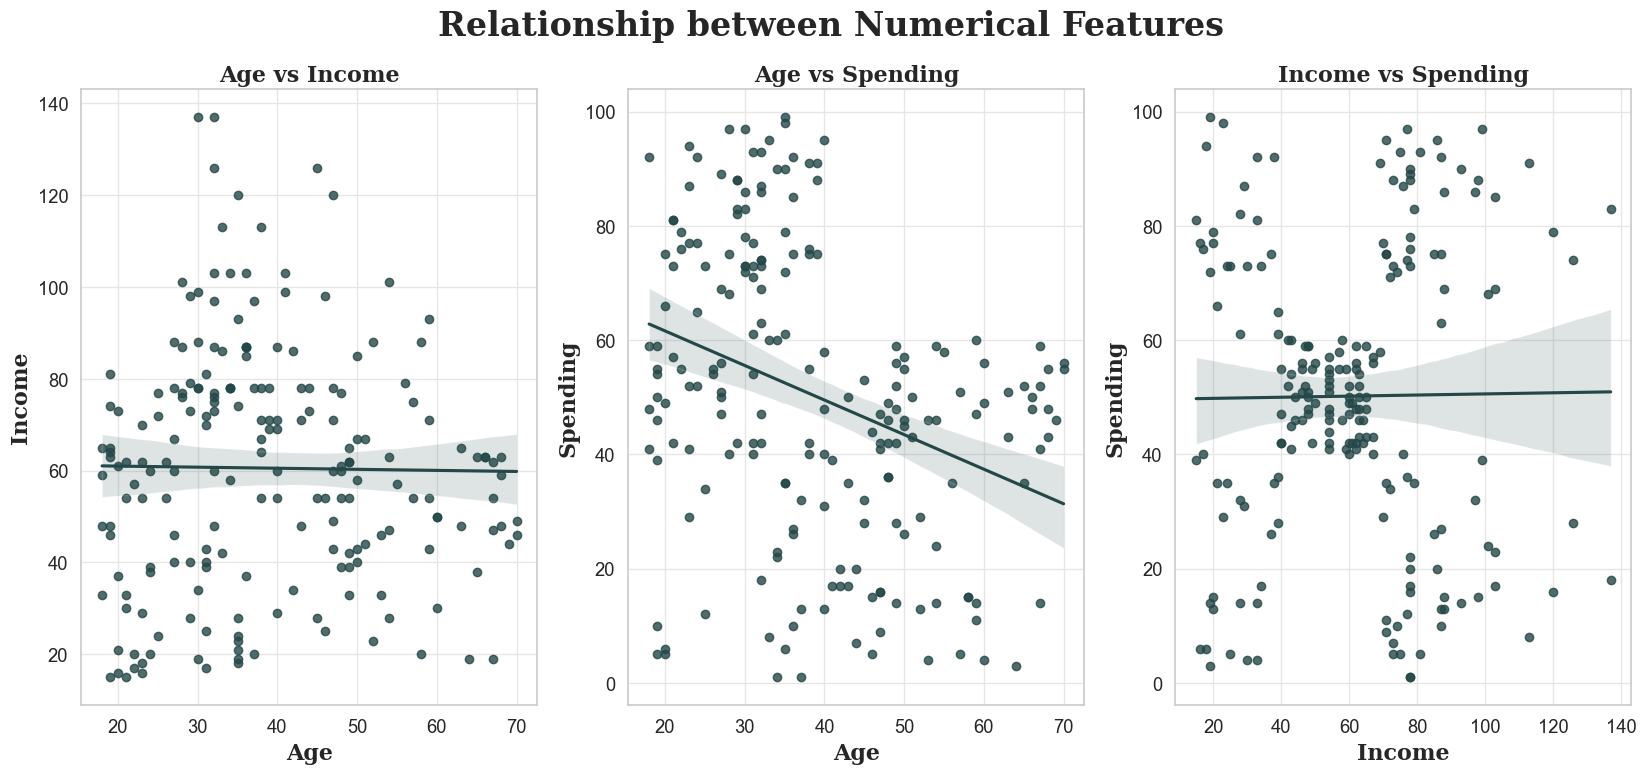

In [15]:
# Compare the relationship between the numerical features using scatterplot
numerical_features = ['Age', 'Income', 'Spending']

fig, axs = plt.subplots(1, 3, figsize=(20,8))
sns.set_context('notebook', font_scale=1.2)

# Set title
fig.suptitle('Relationship between Numerical Features', fontsize=24, fontweight='bold', fontfamily='serif')

counter = 0
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        n1, n2 = numerical_features[i], numerical_features[j]
        sns.regplot(ax=axs[counter], data=df_eda, x=n1, y=n2, color='#244747')
        axs[counter].set_xlabel(n1, fontsize=16, fontweight='bold', fontfamily='serif')
        axs[counter].set_ylabel(n2, fontsize=16, fontweight='bold', fontfamily='serif')
        axs[counter].set_title(f"{n1} vs {n2}", fontsize=16, fontweight='bold', fontfamily='serif')
        counter += 1

plt.show()



**Observations**:
- From this graph, we notice that the regression lines for Age vs Incoe and Income vs Spending is a horizontal line, this means that r is close to 0 and there is virtually no relationship between the two variables
- On the otherhand, the regression line for Age vs Spending suggests that that there is a negative linear relationship between age and spending and as Age increases, Spending will decrease
- From the scatterplot of Income vs Spending, it seems that there is already some observable clusters


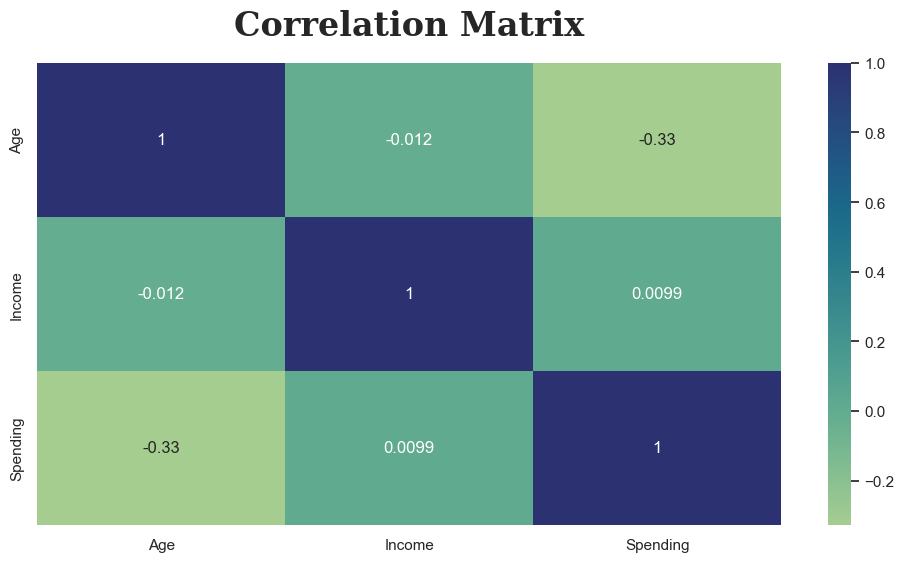

In [16]:
# Plot correlation matrix
plt.figure(figsize=(12, 6))

# Set font scale
sns.set_context('notebook', font_scale=1)

# Set grid color
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Remove the frame
plt.box(False)

# Plot heatmap
sns.heatmap(df_eda.corr(), annot=True, cmap='crest')

# Set title
plt.title('Correlation Matrix', fontweight='bold', fontfamily='serif', fontsize=24, pad=20)

plt.show()

**Observations**:
- The correlation matrix shows that there is little correlation between the different numerical features

## 2. Data Preparation

#### **Feature Scaling**

In [17]:
# Scale Numerical Features
numerical_features = ['Age', 'Income', 'Spending']
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])
print('SCALED VALUES:')
display(df_scaled[numerical_features].head())

SCALED VALUES:


,Age,Income,Spending
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


#### **Categorical Encoding**

In [18]:
# Label Encoding
df_enc = df.copy()
labelEnc = LabelEncoder()
df_enc['Gender'] = pd.DataFrame(labelEnc.fit_transform(df_enc['Gender']))
print('LABEL ENCODED VALUES:')
display(df_enc['Gender'].head())

LABEL ENCODED VALUES:


0    1
1    1
2    0
3    0
4    0
Name: Gender, dtype: int32

In [19]:
df_preprocessed = df_scaled.copy()
df_preprocessed['Gender'] = df_enc['Gender']
display(df_preprocessed.head())

,Gender,Age,Income,Spending
0,1,-1.424569,-1.738999,-0.434801
1,1,-1.281035,-1.738999,1.195704
2,0,-1.352802,-1.700830,-1.715913
3,0,-1.137502,-1.700830,1.040418
4,0,-0.563369,-1.662660,-0.395980


In [20]:
X = df_preprocessed.values
print(X[:5])

[[ 1.         -1.42456879 -1.73899919 -0.43480148]
 [ 1.         -1.28103541 -1.73899919  1.19570407]
 [ 0.         -1.3528021  -1.70082976 -1.71591298]
 [ 0.         -1.13750203 -1.70082976  1.04041783]
 [ 0.         -0.56336851 -1.66266033 -0.39597992]]


## 3 Clustering

#### **Clustering Tendency Assessment**

Clustering Tendency Assessment is used to determine whether a given dataset contains any meaningful structure or not (i.e. non random structures within the dataset). One common way to assess clustering tendency is through Hopkins Statistics which is a hypothesis test where the null hypothesis is that the data is uniformly and randomly distributed

**Explanation of Hopkins Statistic**

Given the set $X$ of $n$ data points:

Step 1: Generate a random sample $\tilde{X}$ of $m$ data points (where $ m < n$) sampled without replacement 

Step 2: Generate a set $Y$ of $m$ uniformly randomly distributed data points

Step 3: Calculate the minimum distance, $u_{i}$ of $y_{i} \in Y$ to its nearest neighbour in $X$

Step 4: Calculate the minimum distance, $w_{i}$ of $\tilde{x_{i}} \in \tilde{X} \in X$ to its nearest neighbour $x_{j}$ in $X$ where $\tilde{x_{i}} \neq x_{j}$



$\begin{equation}
H = \frac{\sum_{i=1}^{m} u_{i}^{d}}{\sum_{i=1}^{m} u_{i}^{d} + \sum_{i=1}^{m} w_{i}^{d}}
\nonumber
\end{equation}$


$H_{0}:$ Data is uniformly randomly distributed

$H_{1}:$ Data is not uniformly randomly distributed

In [21]:
# Implementing Hopkins Statistic
def hopkins(X, portion=0.1, seed=42):
  """
    X: numpy array of shape (n_samples, n_features)
    portion: portion of X to be used for the Hopkins statistic calculation (portion < 1)
    seed: random seed
  """
  
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n) 

  np.random.seed(seed)
  # n_neighbors = 1 because we are only interested in the distance between the point and its nearest neighbor
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)

  # u_dist
  # Create m random points that are uniformly distributed within the range of X
  Y = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(Y, return_distance=True)[0]

  # w_dist
  # Randomly sample m observations from X
  idx = np.random.choice(n, size=m, replace=False)
  # Use 2 instead of 1 because the nearest neighbor is the point itself
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  # u_dist/w_dist: numpy array of shape (m,)
  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

In [22]:
# Check the Hopkins Statistic of the preprocessed data
print('Hopkins Statistic:', hopkins(X))

Hopkins Statistic: 0.9787629183060007


**Intepreting Hopkin's Statistic**
- 0 - 0.3 => Regularly Spaced Data
- $\approx$ 0.5 => Random Data
- 0.7 - 1 => Clustered Data

Since we got a value of 0.979, it suggests that the dataset is suitable for clustering

### **K-Means**

K-Means is a centroid-based clustering algorithm. It works by:
1. Initializing k centroids
2. Assign each point to its closest centroid
3. Compute the new centroid of each cluster by taking the mean of all the data points in the cluster
4. Repeat step 2-3 until the centroid positions do not change

<ins>*K-Means++*</ins>

In the traditional K-means algorithm, the k centroids are initialized randomly. However, we will be using k-means++ to initialize the initial positions of the centroids. k-means++ is a smart centroid initialization method where the goal is to spread out the initial centroid positions. This is done by assigning the first centroid randomly then selecting the rest of the centroids based on the maximum squared distance in order to push the centroids as far as possible from one another

There are several methods to determine an appropriate value of K to use:
- Elbow Method
- Silhouette Score 

In [23]:
cluster_range = list(range(2,11))
print(cluster_range)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


**Elbow Method**

The elbow method is a heuristic in Mathematical optimization to choose a point where diminishing returns are no longer worth the additional cost. In this case, we want a value of inertia that is low without our number of clusters being too large.

An elbow plot shows at what value of k the distance between the mean of a cluster and the other data points in the cluster is at its lowest. There are two values which can be used to measure this distance:

<ins>Inertia</ins>

Inertia is the sum of squared distances from each point ($x_{i}$) to its cluster ($C_{k}$)

$\begin{equation}
{Inertia} = \sum_{i-1}^{N} (x_{i} - C_{k})^2
\nonumber
\end{equation}$

<ins>Distortion</ins>

Distortion, on the other hand, is the average of each point ($x_{i}$) to its cluster ($C_{k}$)

$\begin{equation}
{Distortion} = \frac{1}{n} \sum_{i-1}^{N} (x_{i} - C_{k})^2
\nonumber
\end{equation}$

<ins>Inertia vs Distortion</ins>

- Inertia will always increase as more members are added into each cluster. However, this will not be the case for distortion since it works by taking the average
- Inertia is used if clusters have *similar number of points* while distortion is used if *similarity of the points* are more important



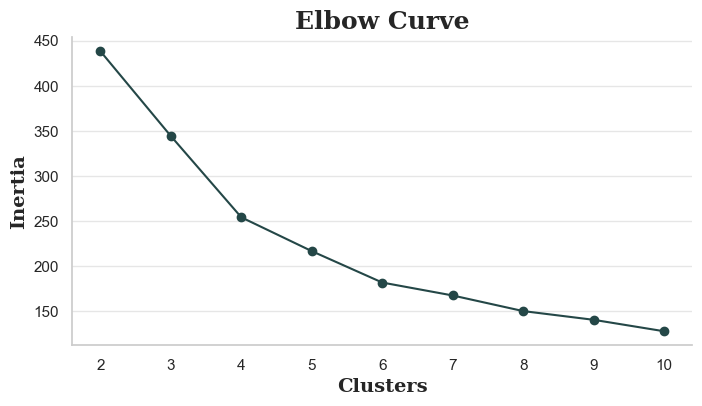

In [24]:
inertia = []

for k in cluster_range:
    model = KMeans(n_clusters=k, init='k-means++').fit(X)
    inertia.append(model.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 4))
sns.set_context('notebook', font_scale=1)
plt.plot(cluster_range, inertia, 'o-', color='#244747')

# Remove the top and right spines from plot
sns.despine()

plt.xlabel('Clusters', fontsize=14, fontweight='bold', fontfamily='serif')
plt.ylabel('Inertia', fontsize=14, fontweight='bold', fontfamily='serif')
plt.xticks(cluster_range)
plt.title('Elbow Curve', fontsize=18, fontweight='bold', fontfamily='serif')

# Remove vertical grid
plt.grid(axis='x', alpha=0)

plt.show()
    

**Observations**:

- From the elbow plot, it seems that the point of inflection is at k=6 which makes our optimal number of clusters is 6. 
- However, it is also not entirely clear so we can confirm our optimal number of clusters by using Silhouette Score

**Silhouette Score**

A higher Silhouette Coefficient score relates to a model with better-
defined clusters.
The Silhouette Coefficient is defined for each sample and is composed
of two scores:
- Mean intra-cluster distance , $a$: The mean distance between a sample and all other points in the cluster it is a part of
- Mean nearest-cluster distance, $b$: The mean distance between a sample and the nearest cluster that the sample is not a part of

The Silhouette Coefficient is for a single sample is then given as:


$\begin{equation}
s(i) = \frac{b(i) - a(i)}{max(a(i) , b(i))}
\nonumber
\end{equation}$

In [25]:
def plot_silhouetteCoeffPlot(
    silhouette_coeff_list,
    cluster_range,
    ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(cluster_range, silhouette_coeff_list, marker="s", color='#244747')

    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Silhouette Coefficient")
    ax.set_xticks(cluster_range)

    ax.set_title("Silhouettes Score")

    return ax

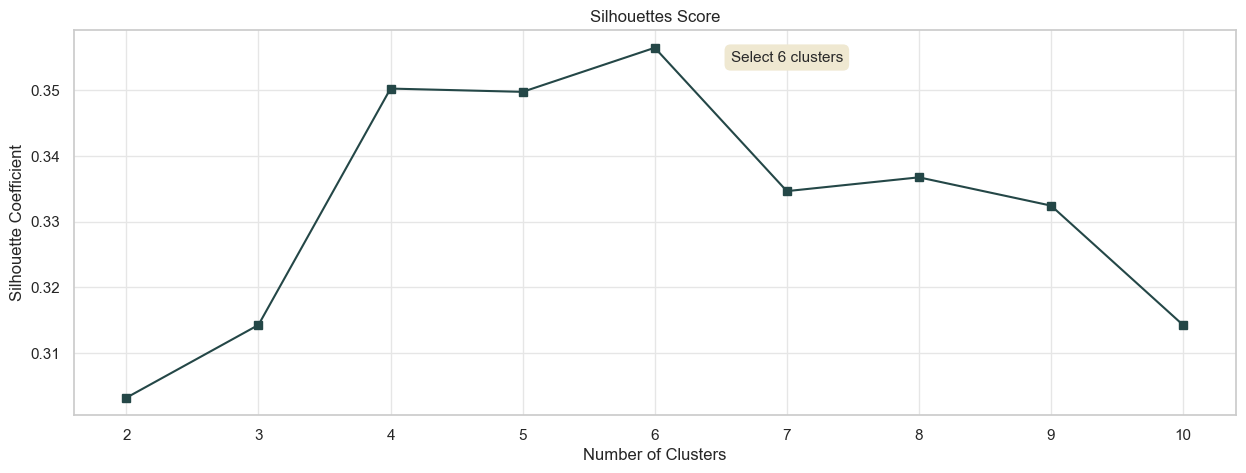

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))

silhouette_score_list = []
for k in cluster_range:
    # Print silhouette score for k clusters
    clusterer = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = clusterer.fit_predict(X) 
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_score_list.append(silhouette_avg)

plot_silhouetteCoeffPlot(silhouette_score_list, cluster_range, ax)

ax.annotate("Select 6 clusters", xy=(7, 0.355), fontsize=11, va = 'center', ha='center', color='#2a2a2a', bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

plt.show()


**Observations**:
- From the plot of the silhouette scores, the silhouette score is the highest when the number of clusters is 6

**Silhouette Plot**

A silhouette plot is a form of silhouette analysis that displays a measure of how close a point in one group is to nearby group. 

The measure has a range form -1 to 1 where a value close to 1 shows that a point is far from the neighboring clusters while a value close to -1 shows that a point is far from neighboring clusters. A value of 0 indicates that the point is incredibly close to the decision boundary between the two neighboring clusters

To analyze the Silhouette plot there are several things to look out for:
-  Sub-optimal n_clusters will show the presence of clusters below the average silhouette score
-  Sub-optimal n_clusters will also show wide fluctuations in the size of the silhouette plot

In [27]:
def plot_silhouettePlot(
        clusterer,
        X, 
        n_clusters,
        ax = None
):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))


    ax.set_title(
    f"n_clusters = {max(n_clusters)}", fontsize=18, fontweight="bold")

    # Compute the silhouette scores for each sample
    cluster_labels = clusterer.fit_predict(X)

    # Color list
    color_list = list(sns.color_palette("flare", len(n_clusters)+1).as_hex()) # type: ignore

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    ax.set_xlim([0, 1]) # type: ignore

    y_lower = 10
    for i in range(max(n_clusters)):
        # Aggregate the silhouette scor es for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i] # type: ignore

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0] # type: ignore
        y_upper = y_lower + size_cluster_i

        color = color_list[i]
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values, # type: ignore
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--") # type: ignore

    # Annotate the value of silhouette score beside the line
    ax.text(
        silhouette_avg + 0.005, # type: ignore
        0.3,
        f"Average:{silhouette_avg:.3f}",
        color="black",
        fontweight="light",
        fontfamily='serif'
    )

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    ax.set_xlabel("Silhouette coefficient values", fontfamily='serif')

    return ax

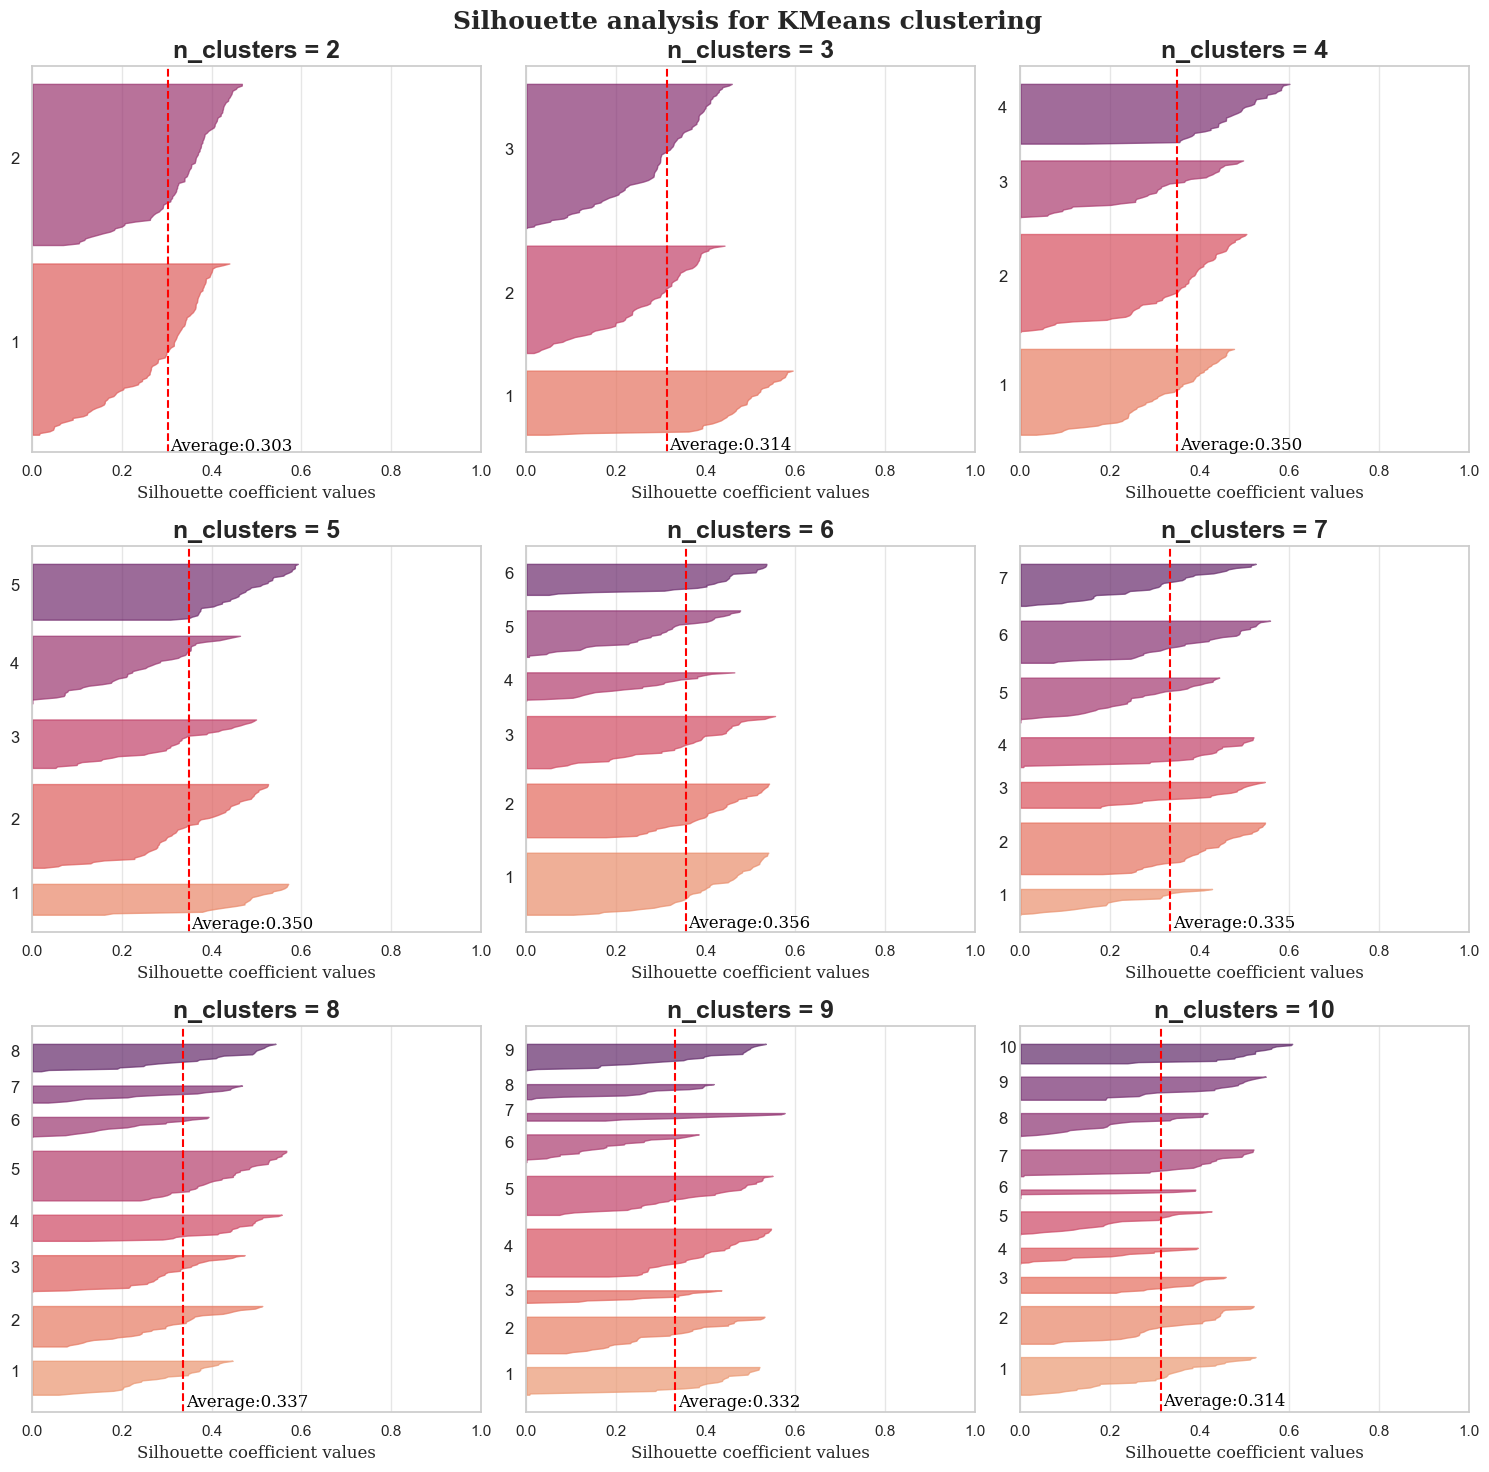

In [28]:
# Clustering silhouette_score
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in cluster_range:
    clusterer = KMeans(n_clusters=i, init='k-means++', random_state=42)
    plot_silhouettePlot(clusterer, X, cluster_range[:i-1], ax=ax[(i-2)//3, (i-2)%3])

plt.suptitle(f"Silhouette analysis for {type(clusterer).__name__} clustering", fontsize=18, fontweight="bold", fontfamily='serif') # type: ignore
plt.tight_layout()
plt.show()

**Observations**:
- From the silhouette plot, none of the n_clusters shows value below the average score (indicated with the red-dotted line)
- A wide fluctuatiion is seen in most of the n_clusters although less in n_clusters 4-6

**TSNE Analysis**

Since our data has four dimensions (spending, income, age and gender), it would be very hard to visualise the clusters even with a 3d plot of the 3 numerical features as the axis.

One way to solve this is to use T-distributed Stochastic Neighbor Embedding (t-SNE) which is a nonlinear dimensionality reduction technique commonly used to visualize high-dimensional data

In [29]:
# Perform t-sne on the data
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(X)

In [30]:
def plot_tsne_analysis(
    tsne_transformed,
    cluster_labels,
    ax=None
):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title('Cluster Analysis using T-SNE', fontsize=18, fontweight='bold', fontfamily='serif', pad=15)

    # Add cluster to tsne_transformed dataframe
    tsne_df = pd.DataFrame(tsne_transformed, columns=['tsne_1', 'tsne_2'])
    tsne_df['Cluster'] = cluster_labels

    # Plot the t-sne plot
    sns.scatterplot(
        x=tsne_df['tsne_1'],
        y=tsne_df['tsne_2'],
        c=tsne_df['Cluster'],
        cmap='tab20',
        ax=ax
    )

    ax.set_xlabel('Dimension 1', fontsize=12, fontweight='light', fontfamily='serif')
    ax.set_ylabel('Dimension 2', fontsize=12, fontweight='light', fontfamily='serif')

    return ax

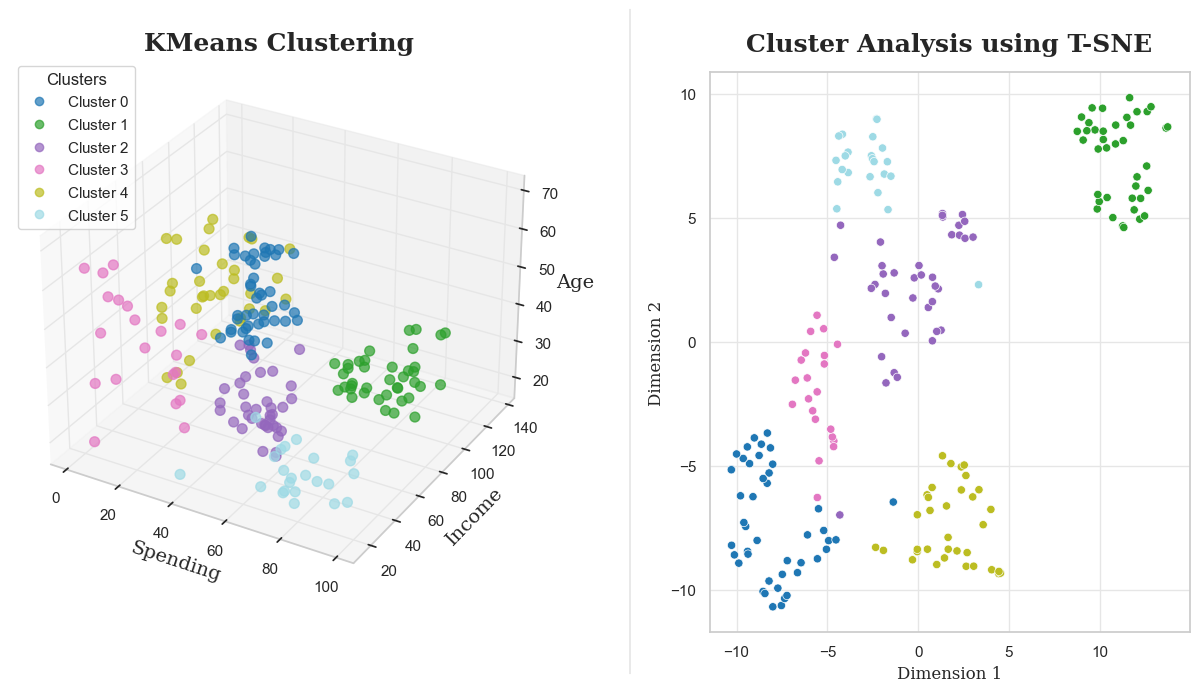

In [31]:
# Instantiate the KMeans algorithm with 6 clusters
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)

# Fit the model to the data
kmeans.fit(X)

kmeans_labels = kmeans.predict(X)

# Add the cluster labels to a dataframe
kmeans_df = df.copy()
kmeans_df['Cluster'] = kmeans_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    kmeans_df['Spending'],
    kmeans_df['Income'],
    kmeans_df['Age'],
    c=kmeans_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

ax.set_xlabel('Spending', fontsize=14, fontweight='light', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='light', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='light', fontfamily='serif')

# Add a title and a legend
ax.set_title('KMeans Clustering', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend = ax.legend(handles, list(map(lambda x: 'Cluster ' + x, labels)), loc="upper left", title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='#656565',lw=0.2) # type: ignore
fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

plot_tsne_analysis(tsne_transformed, kmeans_labels, ax=ax2)

plt.show()

**Observations**:
- It seems that the clusters are quite well-defined with each cluster being rather distinct from the other clusters

### **Agglomerative Clustering**

Agglomerative Clustering is a form of hierarchical clustering that works in a bottom-up approach. Initially, each data point is a cluster of its own and then further pairs of clusters are merged as it moves up the hierarchy. It works by:
1. Have every data point as a cluster of its own
2. Take two nearest cluster and join them to form one single cluster
3. Repeat step 2 until you obtain the desired number of clusters


There are several methods to determine an appropriate value of K to use:
- Silhouette Score 
- Dendrogram (specific to Agglomerative Clustering)

**Silhouette Score**

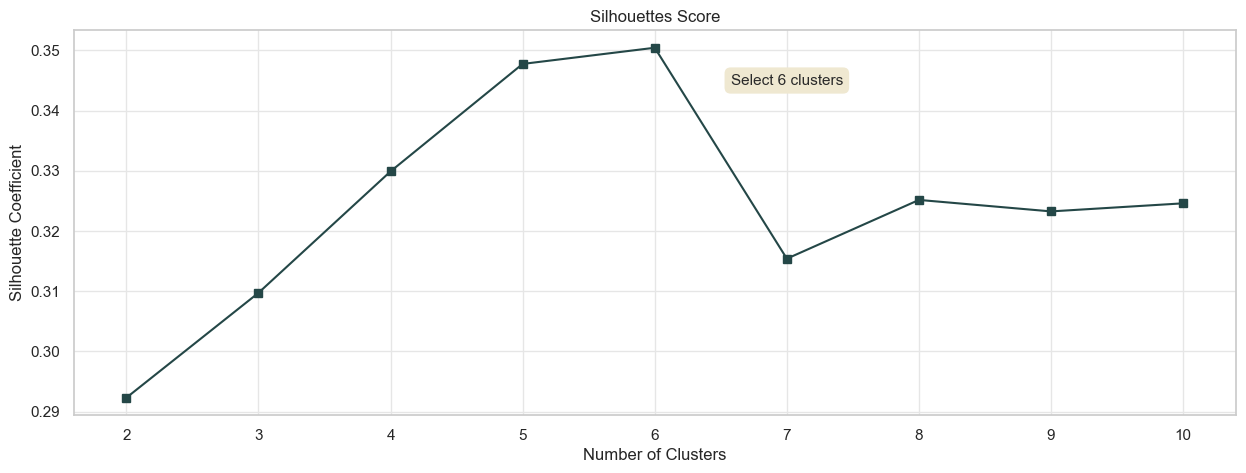

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))

silhouette_score_list = []
for k in cluster_range:
    # Print silhouette score for k clusters
    clusterer = AgglomerativeClustering(k)
    cluster_labels = clusterer.fit_predict(X) 
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_score_list.append(silhouette_avg)

plot_silhouetteCoeffPlot(silhouette_score_list, cluster_range, ax)

ax.annotate("Select 6 clusters", xy=(7, 0.345), fontsize=11, va = 'center', ha='center', color='#2a2a2a', bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

plt.show()


**Observations**:
- From the plot of the silhouette scores, the silhouette score is the highest when the number of clusters is 6

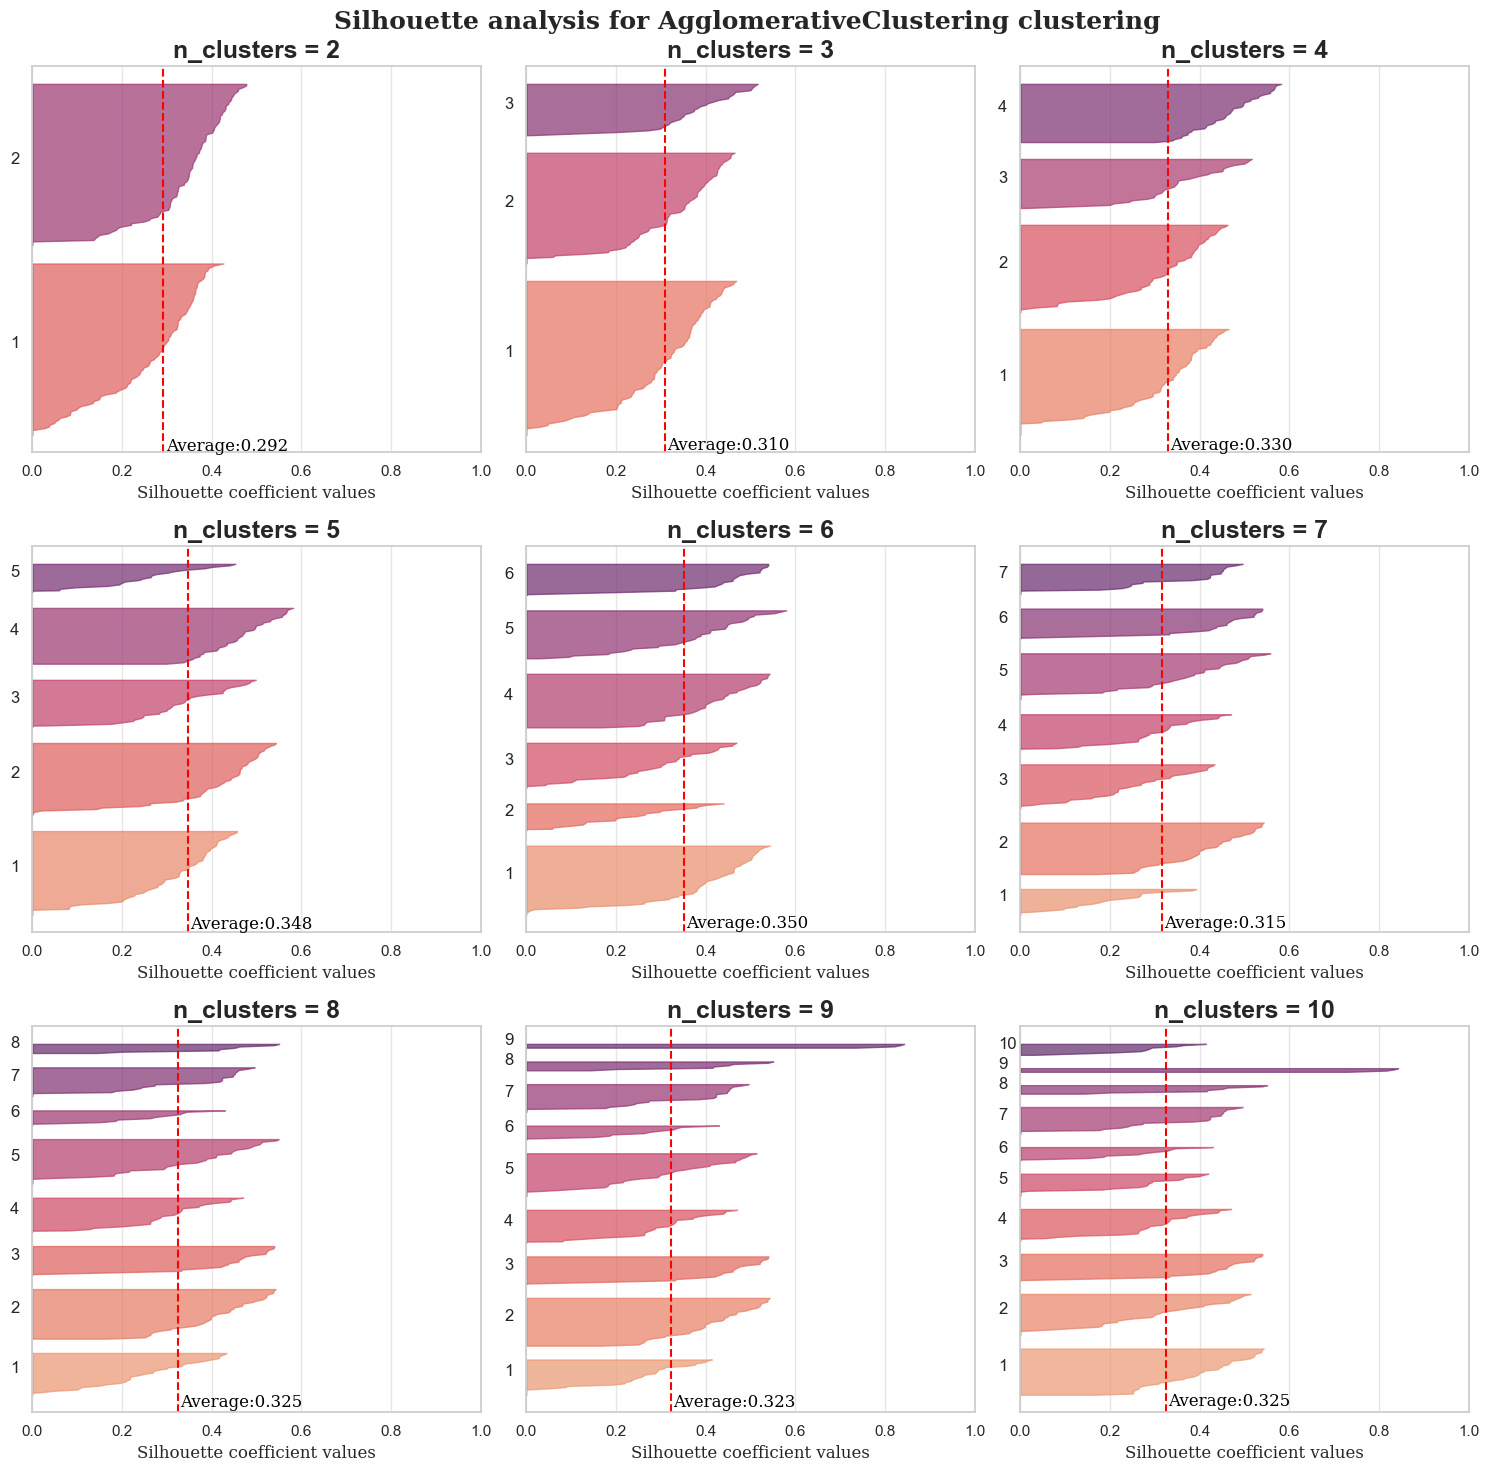

In [33]:
# Clustering silhouette_score
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in cluster_range:
    clusterer = AgglomerativeClustering(n_clusters=i)
    plot_silhouettePlot(clusterer, X, cluster_range[:i-1], ax=ax[(i-2)//3, (i-2)%3])

plt.suptitle(f"Silhouette analysis for {type(clusterer).__name__} clustering", fontsize=18, fontweight="bold", fontfamily='serif')
plt.tight_layout()
plt.show()

**Observations**:
- From the silhouette plot, none of the n_clusters shows value below the average score (indicated with the red-dotted line)
- A wide fluctuatiion is seen in most of the n_clusters although less in n_clusters 5 and 6

**Dendrogram**

A dendogram is a diagram commonly used in hierarchical clustering algorithms to show the attribute distances between each pair of sequentially merged classes. 

The way to intepret a dendogram is by identifying the largest vertical difference in height among the branches and in the middle pass a horizontal line. The number of branches intersecting the horizontal line is the optimal number of clusters

In [34]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    color_list = list(sns.color_palette("crest", 4).as_hex())
    set_link_color_palette(color_list)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

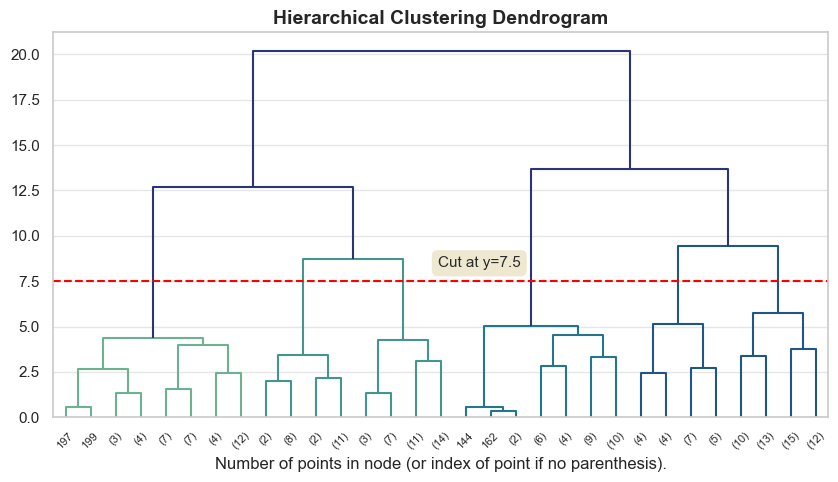

In [35]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)

plt.figure(figsize=(10, 5))

plt.title("Hierarchical Clustering Dendrogram", fontsize=14, fontweight="bold")
# plot the top three levels of the dendrogram
above_threshold_color = list(sns.color_palette("crest", 50).as_hex())[49]
plot_dendrogram(model, truncate_mode="level", p=4, color_threshold=12.5, above_threshold_color=above_threshold_color)

plt.xlabel("Number of points in node (or index of point if no parenthesis).")

# Cut at y=7.5
plt.axhline(y=7.5, color='r', linestyle='--')
plt.annotate('Cut at y=7.5', xy=(0.55, 0.4), xycoords='axes fraction', fontsize=11, va = 'center', ha='center', color='#2a2a2a', bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

# Remove x-axis grid lines
plt.grid(False, axis='x')

plt.show()

**Observations**:
- From the dendogram, it seems that the perfect balance between number of clusters and the vertical difference in height between the branches seem to be around the range y=5.0 to around y=8. 
- Splitting the dendogram in this interval gives us a total of 6 clusters

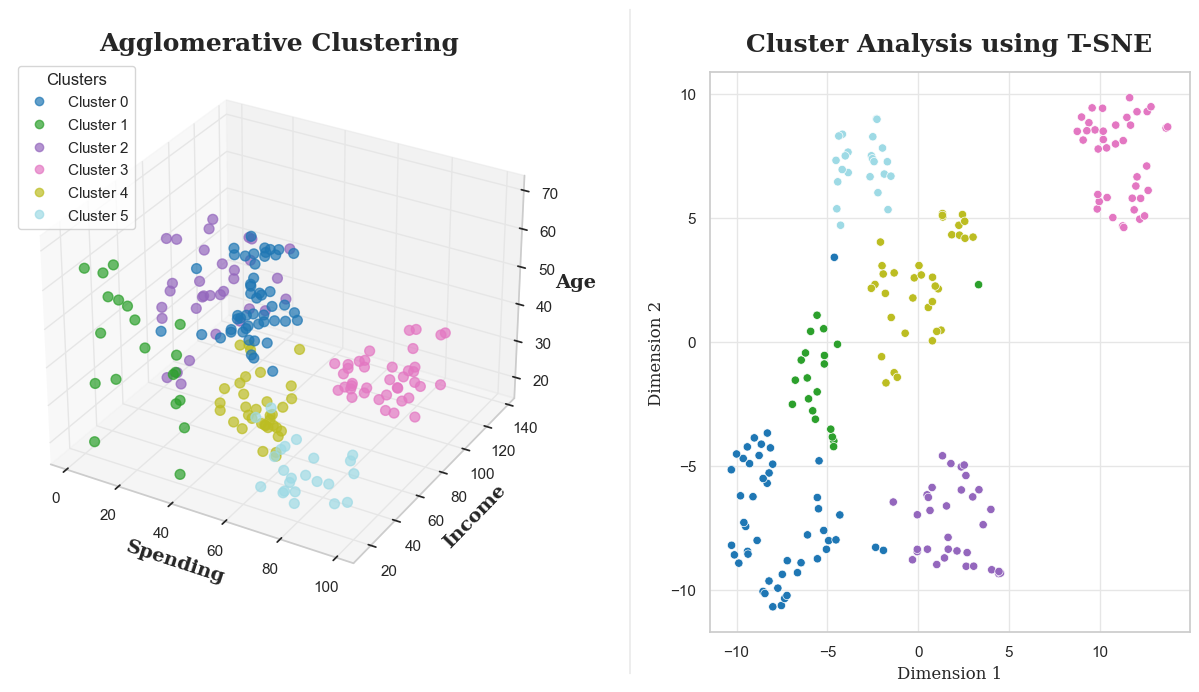

In [36]:
# Instantiate AgglomerativeClustering with 6 clusters
aggClus = AgglomerativeClustering(n_clusters=6)

# Fit aggClus to the dataset
aggClus.fit(X)

aggClus_labels = aggClus.labels_

# Add the cluster labels to a dataframe
aggClus_df = df.copy()
aggClus_df['Cluster'] = aggClus_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    aggClus_df['Spending'],
    aggClus_df['Income'],
    aggClus_df['Age'],
    c=aggClus_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Agglomerative Clustering', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop='colors', alpha=0.7)
legend = ax.legend(handles, list(map(lambda x: 'Cluster ' + x, labels)), loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore
fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

plot_tsne_analysis(tsne_transformed, aggClus_labels, ax=ax2)

plt.show()


**Observations**:
- It seems that the clusters are quite well-defined with each cluster being rather distinct from the other clusters
- The clusters that are formed also seems quite similar to the clusters formed by KMeans

### **Gaussian Mixture Model (GMM)**

Gaussian Mixture Model is a distribution based clustering algorithim that uses soft clustering instead of hard clustering. In algorithms like KMeans which uses hard clustering, each data point can only belong to one cluster. However in soft clustering, the output of each data point is a probability likelihood of it belonging to each pre-defined number of clusters. 

In order to cluster a group of data points into k different clusters, there would be k different gaussians and each point would be clustered based on how close they are to the gaussians.

It works by:
1. Initiating k random gaussians (i.e. random means and covariance for each gaussian)
2. Appoint each data point a probability likelihood based on its distance to all k Gaussians
3. Recalculate the position of each Gaussian based on the appointed probability likelihood of each data point
4. Repeat steps 2-3 until the each Gaussian does not change much


There are several methods to determine number of components to use:
- Akaike Information Criterion (AIC)
- Bayesian Information Criterion (BIC)

**Akaike Information Criterion (AIC)**

AIC is used for model selection for models that fit under the maximum likelihood estimation framework (i.e. the model's parameters are estimated to try find the parameters that makes the observed data most likely).

<ins>Formula</ins>:

$\begin{equation}
AIC = 2k - 2ln(L)
\nonumber
\end{equation}$

Where,
- $k$: Number of independent features
- $L$: Log-likelihood estimate



**Bayesian Information Criterion (BIC)**

BIC, like AIC, is used for models that fit under the maximum likelihood estimation framework. Unlike AIC, BIC uses the number of examples in the training dataset 

<ins>Formula</ins>:

$\begin{equation}
AIC = k \, ln(n) - 2ln(L)
\nonumber
\end{equation}$

Where,
- $k$: Number of independent features
- $L$: Log-likelihood estimate
- $N$: Number of examples in the training dataset

<ins>AIC VS BIC</ins>

The main difference between AIC and BIC is that BIC is more consistent which will select the true model with probability increasing as n increases. AIC is not as consistent because it has a chance of choosing unecessarily complex model as n becomes too large.

Another difference between AIC and BIC is that BIC considers Type I error and Type II error to be equally undesirble while AIC considers Type II error to be more undesirable than Type I errors unless n is very small

Lowest BIC: 9 clusters
Lowest AIC: 10 clusters


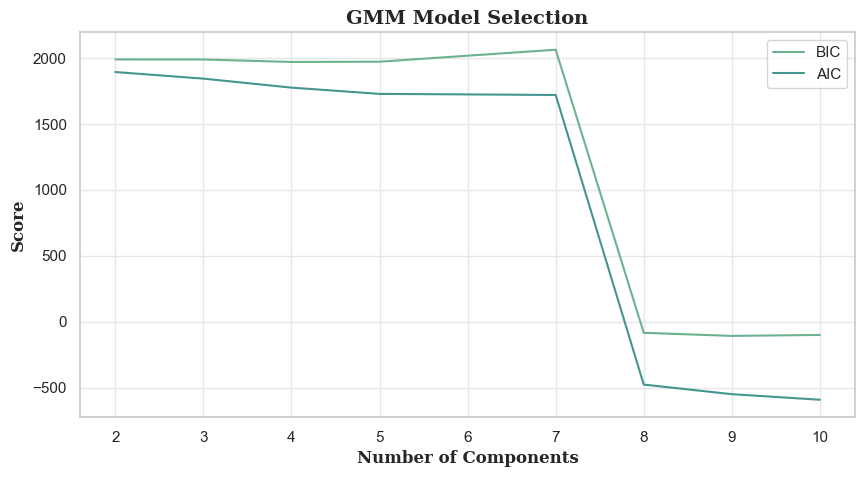

In [37]:
# Compute GMM using AIC and BIC
models = [GaussianMixture(n, covariance_type='full', random_state=420).fit(X) for n in cluster_range]

plt.figure(figsize=(10, 5))

color_list = list(sns.color_palette("crest", 4).as_hex())

BIC_list = [m.bic(X) for m in models]
lowest_BIC = BIC_list.index(min(BIC_list)) + 2
AIC_list = [m.aic(X) for m in models]
lowest_AIC = AIC_list.index(min(AIC_list)) + 2

plt.plot(cluster_range, BIC_list, label='BIC', color=color_list[0])
plt.plot(cluster_range, AIC_list, label='AIC', color=color_list[1])

print(f"Lowest BIC: {lowest_BIC} clusters")
print(f"Lowest AIC: {lowest_AIC} clusters")

plt.title('GMM Model Selection', fontsize=14, fontweight='bold', fontfamily='serif')
plt.xlabel('Number of Components', fontsize=12, fontweight='bold', fontfamily='serif')
plt.ylabel('Score', fontsize=12, fontweight='bold', fontfamily='serif')

plt.legend(loc='best')
plt.show()

**Observations**:
- From the graph, the optimal number of components for GMM is 8 components since it is the point of diminishing returns where the AIC and BIC significantly decreased from 7-8 but the decrease from 8 ownwards is not as significant

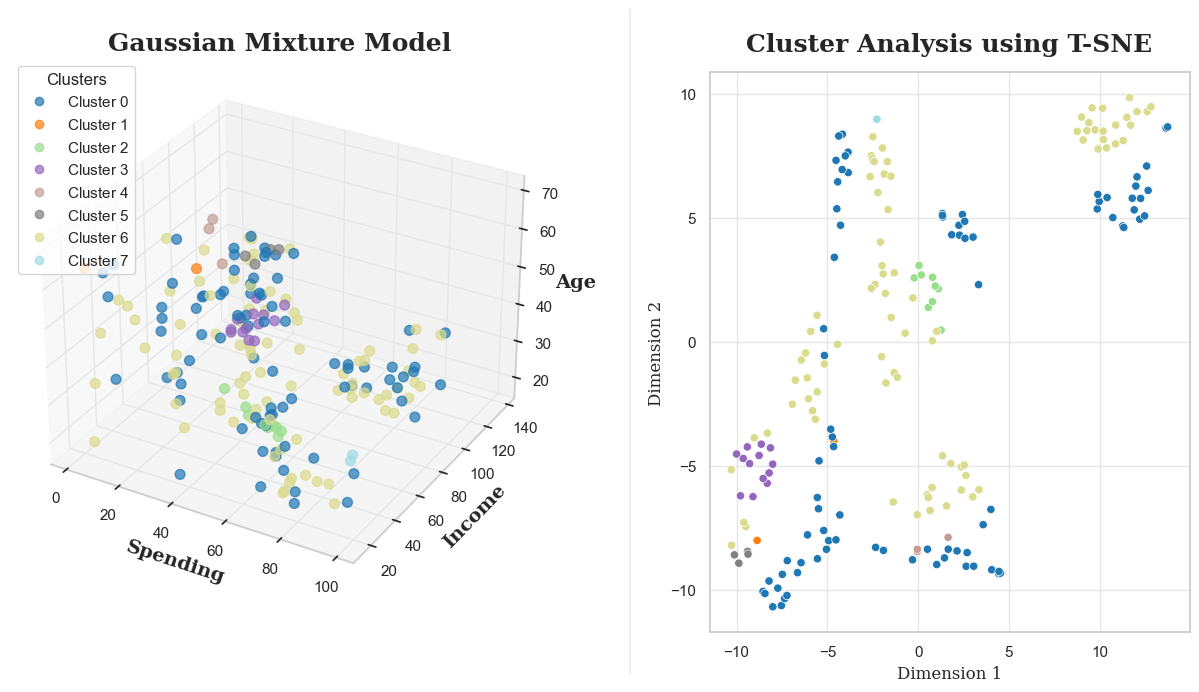

In [38]:
# Instantiate Gaussian Mixture Model with 6 clusters
GMM = GaussianMixture(8, covariance_type='full', random_state=420)

# Fit aggClus to the dataset
GMM.fit(X)

# Get the cluster labels
GMM_labels = GMM.predict(X)

# Add the cluster labels to a dataframe
GMM_df = df.copy()
GMM_df['Cluster'] = GMM_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    GMM_df['Spending'],
    GMM_df['Income'],
    GMM_df['Age'],
    c=GMM_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Gaussian Mixture Model', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop='colors', alpha=0.7)
legend = ax.legend(handles, list(map(lambda x: 'Cluster ' + x, labels)), loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore
fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

plot_tsne_analysis(tsne_transformed, GMM_labels, ax=ax2)

plt.show()

**Observations**:
- It seems that GMM gives us a lot of clusters that are not well-defined with some clusters like cluster 1 and cluster 7 having only 1-2 data points
- In order to obtain better clusters for customer segmentation, we can try to tune the hyperparameters of GMM and get the best model based on their BIC Score

In [39]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# Hyperparameter tuning for GMM
grid = {
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_iter': [30, 40, 50]
}

# Instantiate GridSearchCV
GMM_grid = GridSearchCV(GaussianMixture(random_state=420), grid, scoring=gmm_bic_score)

GMM_grid.fit(X)

# Get the best model
print(GMM_grid.best_estimator_)
print(GMM_grid.best_params_)

tuned_GMM = GMM_grid.best_estimator_

# Get silhouette score for the best model
GMM_grid_score = silhouette_score(X, tuned_GMM.predict(X))
print(GMM_grid_score)

GaussianMixture(covariance_type='diag', max_iter=30, n_components=7,
                random_state=420)
{'covariance_type': 'diag', 'max_iter': 30, 'n_components': 7}
0.3116628961649875


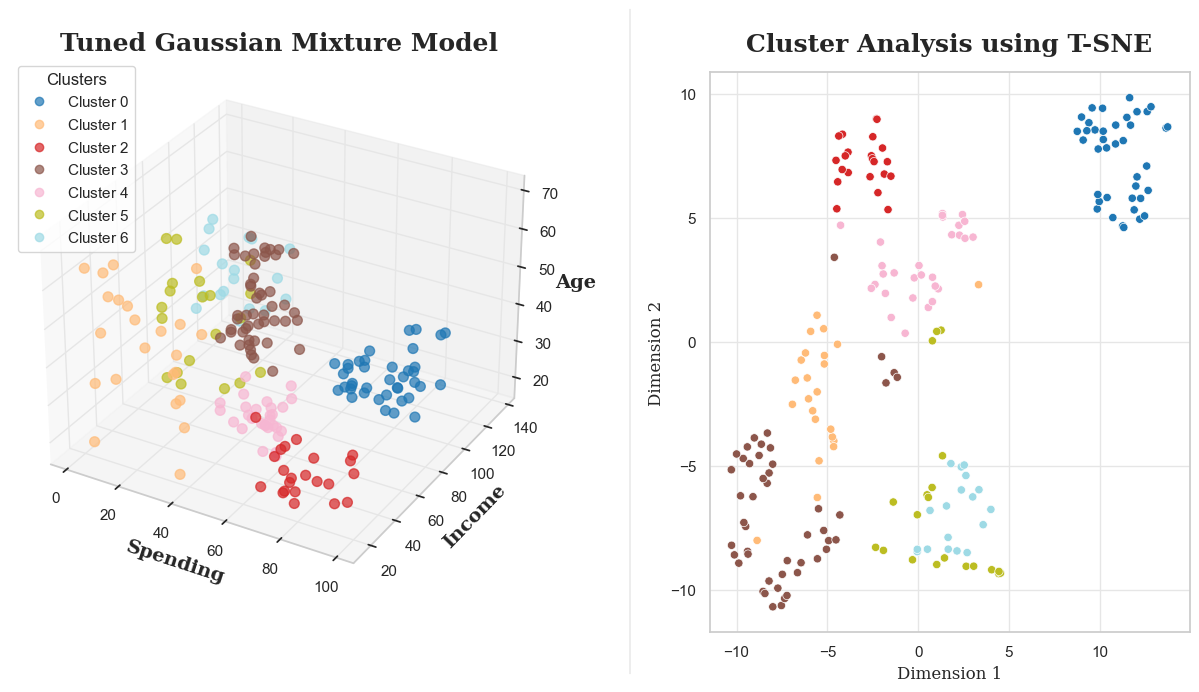

In [40]:
# Visualize the clusters
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

tuned_gmm_df = df.copy()
tuned_gmm_df['Cluster'] = tuned_GMM.predict(X)

# Plot the clusters
scatter = ax.scatter(
    tuned_gmm_df['Spending'],
    tuned_gmm_df['Income'],
    tuned_gmm_df['Age'],
    c=tuned_gmm_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Tuned Gaussian Mixture Model', fontsize=18, fontweight='bold', fontfamily='serif')

handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.7)
labels = list(map(lambda x: 'Cluster ' + x, labels1))

# Combine both legends
legend = ax.legend(handles1, labels, loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore
fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

plot_tsne_analysis(tsne_transformed, tuned_GMM.predict(X), ax=ax2)

plt.show()

**Observations**:
- After tuning, we get more well-defined clusters from GMM. However, there are still some clusters that are unnecessarily split into multiple clusters like how cluster 5 and 6 both represent middle aged customers with high income and low spending but yet are in two seperate clusters instead of one

### **DBSCAN (Density Based Spatial Clustering of Applications with Noise)**

Density Based Spatial Clustering of Applications with Noise (DBSCAN) is a density based clustering algorithim that groups densely grouped data points into a single cluster. It can identify clusters in large spatial datasets by looking at the density of the data points.

One unique aspect of DBSCAN is that it is robust to outliers and does not require the number of clusters to be specified beforehand unlike algorithms like K-Means which requires the number of centroids to be specified.

DBSCAN requires only two parameters:
- Epsilon => the radius of the circle (or a hypersphere in higher order dimensions) to be created around each data point to check the density
- minPoints => the minimum number of data points required inside that circle for that data point to be classified as a Core point

Essentially, for a given set of data points, DBSCAN:
1. Creates a circle of epsilon radius around every data point and classifies them into Core point, Border point and Noise. 
   - A data point is a core point if the circle around it contains at least 'minPoints' number of points
   - It is a border point if the number of points are less than 'minPoints'
   - and it is considered noise if there are no other data point within epsilon radius



For DBSCAN, you cannot choose the number of clusters as it is based on the values of epsilon and min_samples 

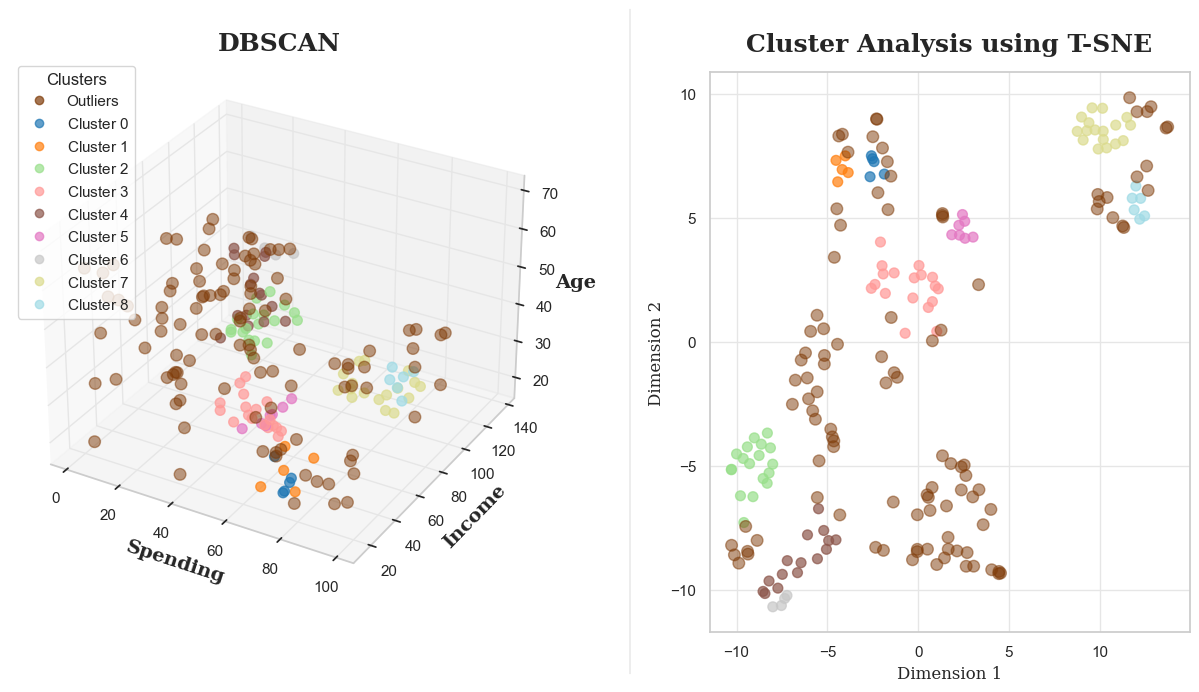

In [41]:
# Instantiate DBSCAN
DBSCANClus = DBSCAN()

# Fit DBSCAN to the dataset
DBSCANClus.fit(X)

# Get the cluster labels
DBSCAN_labels = DBSCANClus.labels_

# Add the cluster labels to a dataframe
DBSCAN_df = df.copy()
DBSCAN_df['Cluster'] = DBSCAN_labels
# Split into 2 dataframe between noise and clusters
DBSCAN_clusters = DBSCAN_df[DBSCAN_df['Cluster'] != -1]
DBSCAN_noise = DBSCAN_df[DBSCAN_df['Cluster'] == -1]


# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(
    DBSCAN_clusters['Spending'],
    DBSCAN_clusters['Income'],
    DBSCAN_clusters['Age'],
    c=DBSCAN_clusters['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Plot the noise
satter_noise = ax.scatter(
    DBSCAN_noise['Spending'],
    DBSCAN_noise['Income'],
    DBSCAN_noise['Age'],
    c=DBSCAN_noise['Cluster'],
    cmap="PuOr",
    s=70,
    alpha=0.5
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('DBSCAN', fontsize=18, fontweight='bold', fontfamily='serif')

handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.7)
handles2, labels2 = satter_noise.legend_elements(prop='colors', alpha=0.7)
labels = ['Outliers'] + list(map(lambda x: 'Cluster ' + x, labels1))
handles = handles2 + handles1

# Combine both legends
legend = ax.legend(handles + handles2, labels, loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore
fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

# Split tsne transformed data into 2 dataframe between noise and clusters
tsne_dbscan_df = pd.DataFrame(tsne_transformed, columns=['x', 'y'])
tsne_dbscan_df['Cluster'] = DBSCAN_labels
tsne_dbscan_clusters = tsne_dbscan_df[tsne_dbscan_df['Cluster'] != -1]
tsne_dbscan_noise = tsne_dbscan_df[tsne_dbscan_df['Cluster'] == -1]

# Plot the clusters
scatter = ax2.scatter(
    tsne_dbscan_clusters['x'],
    tsne_dbscan_clusters['y'],
    c=DBSCAN_clusters['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Plot the noise
satter_noise = ax2.scatter(
    tsne_dbscan_noise['x'],
    tsne_dbscan_noise['y'],
    c=DBSCAN_noise['Cluster'],
    cmap="PuOr",
    s=70,
    alpha=0.5
)

ax2.set_title('Cluster Analysis using T-SNE', fontsize=18, fontweight='bold', fontfamily='serif', pad=15)
ax2.set_xlabel('Dimension 1', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_ylabel('Dimension 2', fontsize=12, fontweight='light', fontfamily='serif')


plt.show()

**Observations**:
- Although DBSCAN provides some well-defined clusters, the size of each cluster is way too small since most of the data points are being labelled as noiise

In order to reduce the number of clusters and to get DBSCAN to give us fewer outliers, we can try to tune the hyperparameters of DBSCAN. The main hyperparameters we are tuning would be:
- min_samples => the number of samples in a neighborhood for a point to be considered as a core point
- epsilon => the maximum distance between two samples for one to be considered as in the nieghbourhood of the other

Since we have 4 dimensions in our dataset, it is recommended to have min_samples >= 4. 

As such we will first start off with a minimum sample of 8 and plot the K-distance graph to try and determine a good value of epsilon to use. The K-distance graph works by:
1. Computing the average of the distances of every point to its K-Nearest Neighbor where the value of K corresponds to the minimum samples
2. The K-Distances are then plotted in ascending order where the aim is to determine the knee (or the point of diminishing returns) which corresponds to the optimal epsilon parameter

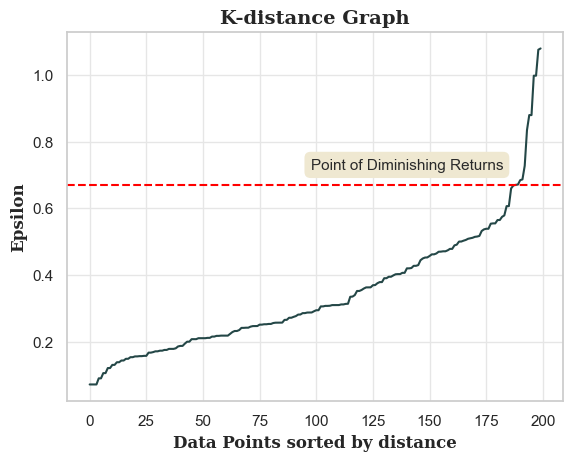

In [42]:
minSamples = 8
neighbors = NearestNeighbors(n_neighbors=minSamples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distance values in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, color='#244747', lw=1.5)

# Add labels and title
plt.title('K-distance Graph', fontsize=14, fontweight='bold', fontfamily='serif')
plt.xlabel('Data Points sorted by distance', fontsize=12, fontweight='bold', fontfamily='serif')
plt.ylabel('Epsilon', fontsize=12, fontweight='bold', fontfamily='serif')

# Annotate at point of diminishing returns
plt.axhline(y=0.67, color='r', linestyle='--')
plt.annotate(
    'Point of Diminishing Returns', xy=(140, 0.73), fontsize=11, va = 'center', ha='center', color='#2a2a2a', bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0) 
)

plt.show()

**Observations**:
- From the graph, it still seems quite hard to determine a good epsilon parameter since the "knee" is not very obvious. 
- As such, we will be using an epsilon value from around 0.5 to 1.0 to tune DBSCAN as well as a minimum sample of 4 to 12

In [43]:
# Hyperparameter tuning for DBSCAN
grid = {
    'eps': np.arange(0.5,1.01,0.01),
    'min_samples': np.arange(4,12,1)
}

def silhouette_scorer(estimator, X):
    """Callable to pass to GridSearchCV that will use the silhouette score."""
    return silhouette_score(X, estimator.fit_predict(X))

# Instantiate GridSearchCV
warnings.filterwarnings('ignore')
DBSCAN_grid = GridSearchCV(DBSCAN(), grid, scoring=silhouette_scorer)

DBSCAN_grid.fit(X)

# Get the best model
print(DBSCAN_grid.best_estimator_)
print(DBSCAN_grid.best_params_)

tuned_DBSCAN = DBSCAN_grid.best_estimator_

# Get silhouette score for the best model
DBSCAN_grid_score = silhouette_score(X, tuned_DBSCAN.fit_predict(X))
print(DBSCAN_grid_score)
warnings.filterwarnings('default')

DBSCAN(eps=0.7900000000000003, min_samples=7)
{'eps': 0.7900000000000003, 'min_samples': 7}
-0.003018287195875182


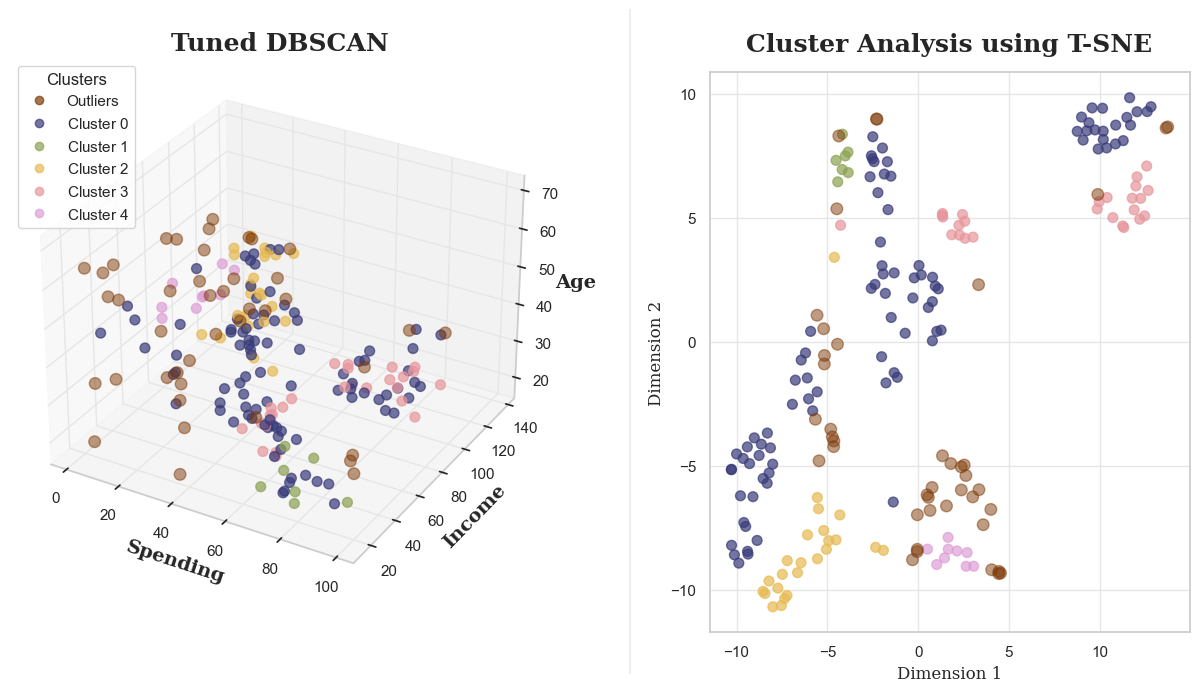

In [44]:
# Instantiate DBSCAN
TunedDBSCANClus = DBSCAN_grid.best_estimator_

# Fit DBSCAN to the dataset
TunedDBSCANClus.fit(X)

# Get the cluster labels
TunedDBSCAN_labels = TunedDBSCANClus.labels_

# Add the cluster labels to a dataframe
TunedDBSCAN_df = df.copy()
TunedDBSCAN_df['Cluster'] = TunedDBSCAN_labels
# Split into 2 dataframe between noise and clusters
TunedDBSCAN_clusters = TunedDBSCAN_df[TunedDBSCAN_df['Cluster'] != -1]
TunedDBSCAN_noise = TunedDBSCAN_df[TunedDBSCAN_df['Cluster'] == -1]


# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(
    TunedDBSCAN_clusters['Spending'],
    TunedDBSCAN_clusters['Income'],
    TunedDBSCAN_clusters['Age'],
    c=TunedDBSCAN_clusters['Cluster'],
    s=50,
    cmap='tab20b',
    alpha=0.7
)

# Plot the noise
satter_noise = ax.scatter(
    TunedDBSCAN_noise['Spending'],
    TunedDBSCAN_noise['Income'],
    TunedDBSCAN_noise['Age'],
    c=TunedDBSCAN_noise['Cluster'],
    cmap="PuOr",
    s=70,
    alpha=0.5
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Tuned DBSCAN', fontsize=18, fontweight='bold', fontfamily='serif')

handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.7)
handles2, labels2 = satter_noise.legend_elements(prop='colors', alpha=0.7)
labels = ['Outliers'] + list(map(lambda x: 'Cluster ' + x, labels1))
handles = handles2 + handles1

# Combine both legends
legend = ax.legend(handles + handles2, labels, loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore
fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

# Split tsne transformed data into 2 dataframe between noise and clusters
tsne_dbscan_df = pd.DataFrame(tsne_transformed, columns=['x', 'y'])
tsne_dbscan_df['Cluster'] = TunedDBSCAN_labels
tsne_dbscan_clusters = tsne_dbscan_df[tsne_dbscan_df['Cluster'] != -1]
tsne_dbscan_noise = tsne_dbscan_df[tsne_dbscan_df['Cluster'] == -1]

# Plot the clusters
scatter = ax2.scatter(
    tsne_dbscan_clusters['x'],
    tsne_dbscan_clusters['y'],
    c=TunedDBSCAN_clusters['Cluster'],
    s=50,
    cmap='tab20b',
    alpha=0.7
)

# Plot the noise
satter_noise = ax2.scatter(
    tsne_dbscan_noise['x'],
    tsne_dbscan_noise['y'],
    c=TunedDBSCAN_noise['Cluster'],
    cmap="PuOr",
    s=70,
    alpha=0.5
)

ax2.set_title('Cluster Analysis using T-SNE', fontsize=18, fontweight='bold', fontfamily='serif', pad=15)
ax2.set_xlabel('Dimension 1', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_ylabel('Dimension 2', fontsize=12, fontweight='light', fontfamily='serif')


plt.show()

**Observations**:
- Even after reducing the number of data points identified as noise, the model still identified a large portion of regular data points as noise
- After tuning, it seems that some of the clusters are no longer as well-defined with a lot of the data points being labelled as 'Cluster 0'

Ultimately, it seems that DBSCAN did not perform well and was not able to fit well to the dataset. One possible reason is because DBSCAN uses density to group clusters together so it would work well for datasets with well-defined dense regions seperated by areas of lower density. 

As such, it might struggle with data that is more uniformly distributed and come up with meaningful clusters

### **Affinity Propagation**

Affinity Propagation is a clusters the dataset by passing messages between data points. 

It works by:
1. Having each data point send messages (*responsibilities*) to all other points informing each target of their relative attractiveness to the sender. 

2. Each target then responds to all senders with a reply informing each sender of its *availability* to associate with the sender given the attractiveness of the messages that it has received from other senders. 

3. The senders then send out another message (*responsibilities*) informing the targets of their revised relative attractiveness given the availability messages it has received from all targets

4. The message-passing procedure repeats until a consensus is reached. Once the sender is associated with one of its targets, the target becomes the point's exemplar where all points with the same exemplar are placed in the same cluster.

<img src="https://www.redalyc.org/journal/3939/393959849001/1982-2170-bcg-24-04-426-gf2.jpg" alt="Affinity Propagation" height='250' width='600'>

Figure: 
Propagation of messages between data points. On the left, "responsibilities" r(i,k) are sent by data point i to candidate exemplar k. On the right, "availabilities" a(i,k) are sent from candidate exemplar k to data point i

In contrast to other traditional clustering methods, Affinity Propagation does not require the number of clusters to be specified.

It takes as input a real number for each data point k which is referred to as a preference. Data points with a large preference are more likely to be exemplars which means that there will be a greater number of clusters.

Note: *Since scikitlearn uses the negative squared Euclidean distance by default to compute the similarity matrix, setting the input preference to the minimal Euclidean distance would result in a positive preference while the values computed in the similarity matrix are negative which will result in as many clusters as samples.*

*As such, we have to use a negative value for the preference parameter*



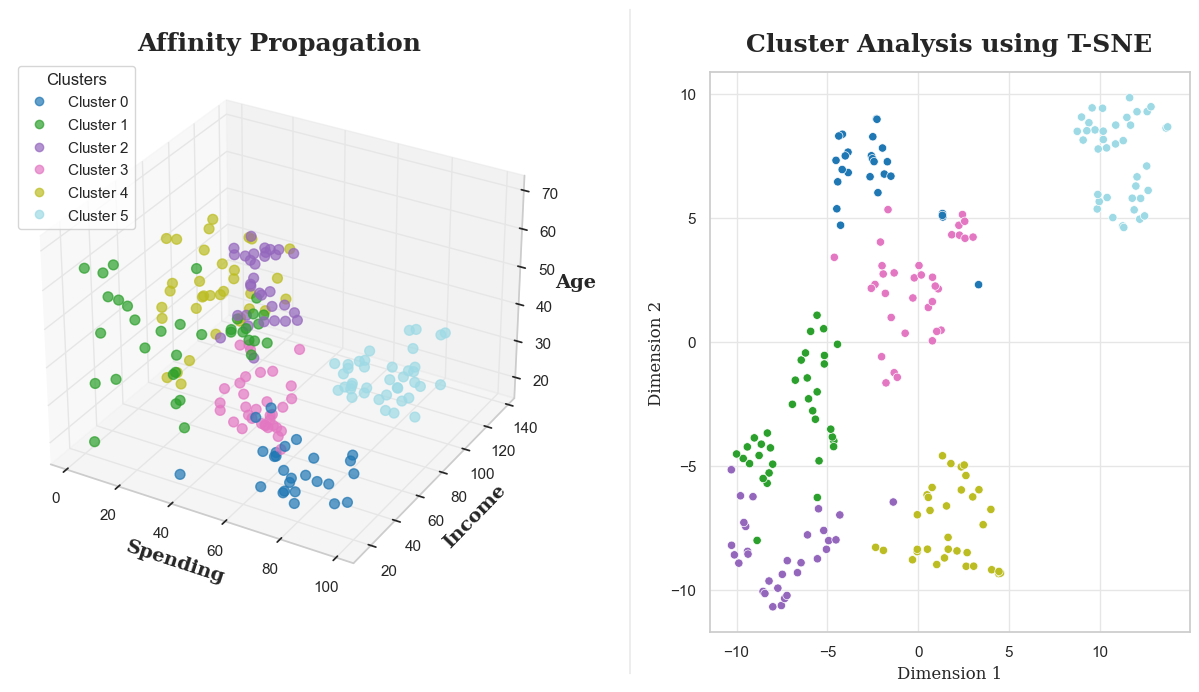

In [45]:
af = AffinityPropagation(random_state=42, preference=-50)

# Fit model to the dataset
af.fit(X)

# Get the cluster labels
af_labels = af.labels_

# Add the cluster labels to a dataframe
af_df = df.copy()
af_df['Cluster'] = af_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(
    af_df['Spending'],
    af_df['Income'],
    af_df['Age'],
    c=af_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Affinity Propagation', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop='colors', alpha=0.7)
labels = list(map(lambda x: 'Cluster ' + x, labels))
legend = ax.legend(handles, labels, loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore

fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

plot_tsne_analysis(tsne_transformed, af_labels, ax=ax2)

plt.show()

**Observations**:
- It seems that the clusters are quite well-defined with each cluster being rather distinct from the other clusters
- The six clusters seem to be quite similar to the clusters from K-Means and Agglomerative Clustering

Although the model gives well-defined clusters, we can still try to improve its performance by tuning several of its hyper parameters and choosing the best parameters that returns the highest silhouette score.
Some of the hyperparameters tuned are:
- Damping => A value ranging from 0.5 to 1.0 which is used as a smoothing factor to ensure a smooth transition between every update
- Preference => The prefence of each point which determines the likelihood for a point to be chosen as exemplars. Points with larger values of preferences are more likely to be chosen as exemplars

In [46]:
grid = {
    'preference': np.linspace(-80, -40, 5),
    'damping': np.linspace(0.5, 1, 5),
}

warnings.filterwarnings('ignore')

def silhouette_scorer(estimator, X):
    """Callable to pass to GridSearchCV that will use the silhouette score."""
    return silhouette_score(X, estimator.predict(X))

silhouette_scorer = make_scorer(silhouette_score)

# Instantiate GridSearchCV
af_grid = GridSearchCV(AffinityPropagation(random_state=42), grid, scoring=silhouette_scorer, n_jobs=-1)
af_grid.fit(X)

# Get the best model
print(af_grid.best_estimator_)
print(af_grid.best_params_)

tuned_af = af_grid.best_estimator_

# Get silhouette score for the best model
af_grid_score = silhouette_score(X, tuned_af.predict(X))
print(af_grid_score)

warnings.filterwarnings('default')

AffinityPropagation(preference=-80.0, random_state=42)
{'damping': 0.5, 'preference': -80.0}
0.33445892200582167


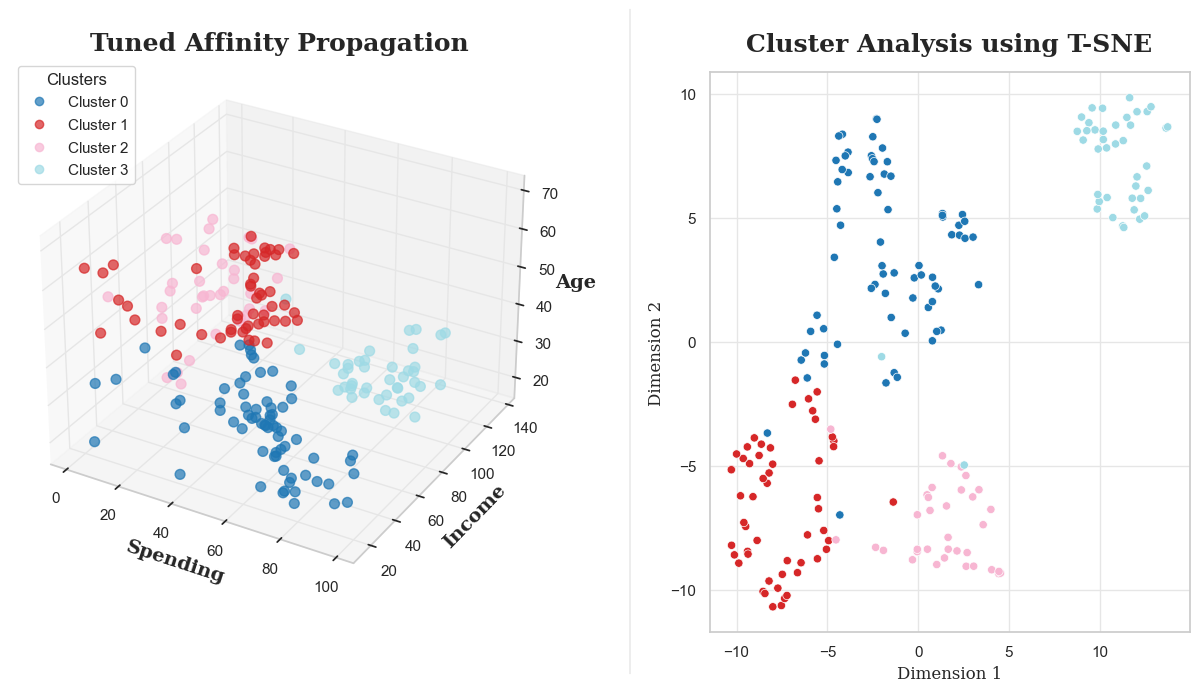

In [47]:
tuned_af = af_grid.best_estimator_

# Fit model to the dataset
tuned_af.fit(X)

# Get the cluster labels
tuned_af_labels = tuned_af.labels_

# Add the cluster labels to a dataframe
tuned_af_df = df.copy()
tuned_af_df['Cluster'] = tuned_af_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(
    tuned_af_df['Spending'],
    tuned_af_df['Income'],
    tuned_af_df['Age'],
    c=tuned_af_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Tuned Affinity Propagation', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop='colors', alpha=0.7)
labels = list(map(lambda x: 'Cluster ' + x, labels))
legend = ax.legend(handles, labels, loc='upper left', title="Clusters")

l1 = lines.Line2D([0.95, 0.95], [0, 0.95], transform=fig.transFigure, figure=fig,color='gray',lw=0.2) # type: ignore

fig.lines.extend([l1]) # type: ignore

# Plot a second plot on the right side of the line
ax2 = fig.add_axes([1.05, 0.06, 0.6, 0.8])

plot_tsne_analysis(tsne_transformed, tuned_af_labels, ax=ax2)

plt.show()


**Observations**:
- After tuning, the number of clusters have decreased to only 4 clusters
- However, they are still as well-defined as before with each cluster being quite unique and distinct from the other clusters

In [48]:
# print average of each cluster
print(tuned_af_df.groupby('Cluster').mean())

               Age     Income   Spending
Cluster                                 
0        27.357143  41.842857  55.042857
1        56.222222  48.814815  42.777778
2        41.800000  85.828571  16.485714
3        33.073171  86.414634  80.487805


## **Model Evaluation**

For model evaluation, we will be using the following metrics:

`Silhouette Score`

A higher Silhouette Coefficient score relates to a model with better-
defined clusters.

$\begin{equation}
s(i) = \frac{b(i) - a(i)}{max(a(i) , b(i))}
\nonumber
\end{equation}$

`Davies Bouldin Score`

Davies Bouldin score is defined as the average similarity measure of each cluster with its most similar cluster. 

The similarity is determined by the ratio of within-cluster distances to between cluster distances. This meansthat clusters which are further apart and less dispersed will result in a better score.

The minimum score is zero with lower values indicating better clustering

`Calinski-Harabasz Index`

The Calinski-Harabasz index is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters.

The higher the score, the better the performances

In [49]:
models = {
    'KMeans': kmeans,
    'Agglomerative Clustering': aggClus,
    'Gaussian Mixture Model': GMM,
    'Tuned Gaussian Mixture Model': tuned_GMM,
    'DBSCAN': DBSCANClus,
    'Tuned DBSCAN': TunedDBSCANClus,
    'Tuned Affinity Propagation': tuned_af,
    'Affinity Propagation': af
}

eval_scores = pd.DataFrame(columns=['NumOfClusters', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score'])

# Get the average silhouette score for each model
for name, model in models.items():
    try:
        labels = model.labels_
    except:
        labels = model.predict(X)

    silhouetteScore = silhouette_score(X, labels)
    daviesBouldinScore = davies_bouldin_score(X, labels)
    calinskiHarabaszScore = calinski_harabasz_score(X, labels)
    num_of_clusters = len(np.unique(labels[labels!=-1]))
    eval_scores.loc[name] = [num_of_clusters, silhouetteScore, daviesBouldinScore, calinskiHarabaszScore] # type: ignore



display(eval_scores.sort_values(by='Silhouette Score', ascending=False))


,NumOfClusters,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score
KMeans,6.0,0.356486,1.005090,99.654879
Agglomerative Clustering,6.0,0.350444,1.008615,95.257661
Tuned Affinity Propagation,4.0,0.334459,1.053139,94.920504
Tuned Gaussian Mixture Model,7.0,0.311663,1.326158,82.305790
Affinity Propagation,6.0,0.305633,1.130486,90.992395
Tuned DBSCAN,5.0,-0.003018,2.027637,18.528488
DBSCAN,9.0,-0.011387,1.500818,10.890569
Gaussian Mixture Model,8.0,-0.191957,1.705812,6.960674


**Observations**:
- It seems that out of all the models, KMeans has the best performance out of the three metrics followed by Agglomerative Clustering as a close second
- Although the silhoutette score improved massively after tuning for Gaussian Mixture Model, it seems that the Davies Bouldin Score and Calinski Harabasz score us still slightly lower than Affinity propagation without tuning even though it has a higher silhouette score. However, it is unlikely that the improvement was caused by overfitting since the improvement in Calinski Harabasz Score is still quite significant after tuning
- Both DBSCAN and the tuned DBSCAN have very poor performances in all three metrics which can mean that DBSCAN is not a good model for the dataset

## **Cluster Intepretation**

For cluster intepretation, we would be intepreting the clusters for KMeans and Tuned Affinity Propagation since they both perform quite well and have slightly different clusters

**<ins>K-Means Cluster Intepretation</ins>**

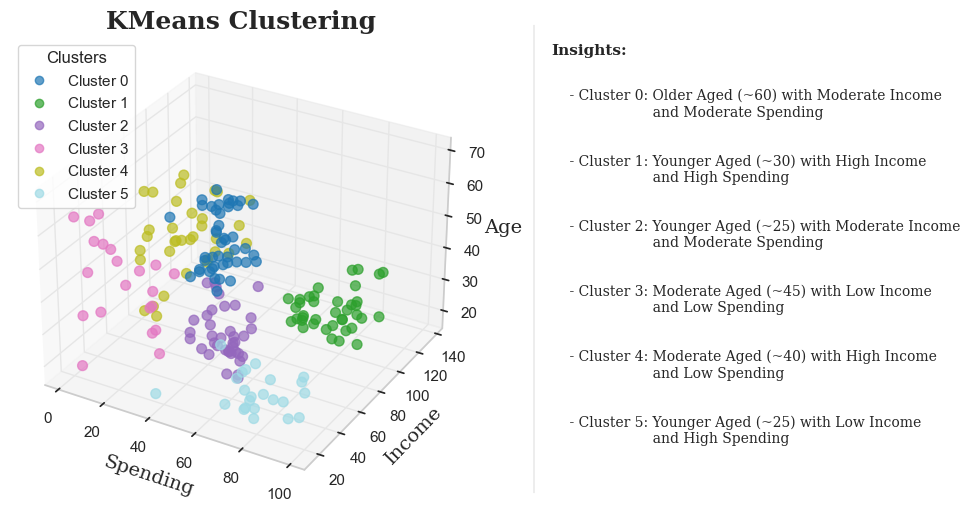

In [50]:
# Instantiate the KMeans algorithm with 6 clusters
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)

# Fit the model to the data
kmeans.fit(X)

kmeans_labels = kmeans.predict(X)

# Add the cluster labels to a dataframe
kmeans_df = df.copy()
kmeans_df['Cluster'] = kmeans_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    kmeans_df['Spending'],
    kmeans_df['Income'],
    kmeans_df['Age'],
    c=kmeans_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

ax.set_xlabel('Spending', fontsize=14, fontweight='light', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='light', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='light', fontfamily='serif')

# Add a title and a legend
ax.set_title('KMeans Clustering', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend2 = ax.legend(handles, list(map(lambda x: 'Cluster ' + x, labels)), loc="upper left", title="Clusters")

l1 = lines.Line2D([1, 1], [0.12, 0.9], transform=fig.transFigure, figure=fig,color='gray',lw=0.2)
fig.lines.extend([l1])

fig.text(
    1.03,
    0.85,
    'Insights:',
    fontsize=11,
    fontweight='bold',
    fontfamily='serif'
)

fig.text(
    1.03,
    0.15,
    '''
    - Cluster 0: Older Aged (~60) with Moderate Income 
                       and Moderate Spending


    - Cluster 1: Younger Aged (~30) with High Income 
                       and High Spending


    - Cluster 2: Younger Aged (~25) with Moderate Income
                       and Moderate Spending


    - Cluster 3: Moderate Aged (~45) with Low Income
                       and Low Spending


    - Cluster 4: Moderate Aged (~40) with High Income
                       and Low Spending


    - Cluster 5: Younger Aged (~25) with Low Income 
                       and High Spending

    ''',
    fontsize=10,
    fontweight='light',
    fontfamily='serif'
)

plt.show()

In [51]:
# Get the summary data for each cluster
kmeans_df.groupby(by=['Cluster']).mean().round(2)

,Age,Income,Spending
Cluster,,,
0,56.33,54.27,49.07
1,32.69,86.54,82.13
2,27.00,56.66,49.13
3,45.52,26.29,19.38
4,41.26,88.50,16.76
5,25.00,25.26,77.61


- Cluster 0: Older Aged (~60) with Moderate Income 
                    and Moderate Spending


- Cluster 1: Younger Aged (~30) with High Income 
                    and High Spending


- Cluster 2: Younger Aged (~25) with Moderate Income
                    and Moderate Spending


- Cluster 3: Moderate Aged (~45) with Low Income
                    and Low Spending


- Cluster 4: Moderate Aged (~40) with High Income
                    and Low Spending


- Cluster 5: Younger Aged (~25) with Low Income 
                    and High Spending


**Observations**:
- From the clusters above, it seems that younger customers (Clusters 1,2 and 5) seem to have a higher spending regardless of income while Middle-Aged customers (Clusters 3 and 4) seem to have a lower spending
- It seems that Clusters 1 and 5 are more valuable to the shopping mall due to their high spending. Given the high income for those from Cluster 1, they would be a more reliable target audience for the shopping ultimately making them the most valuable out of all 6 clusters
- The shopping mall can also try to target customers in Cluster 4 since they are High Income customers but with Low Spending

**<ins>Affinity Propagation Cluster Intepretation</ins>**

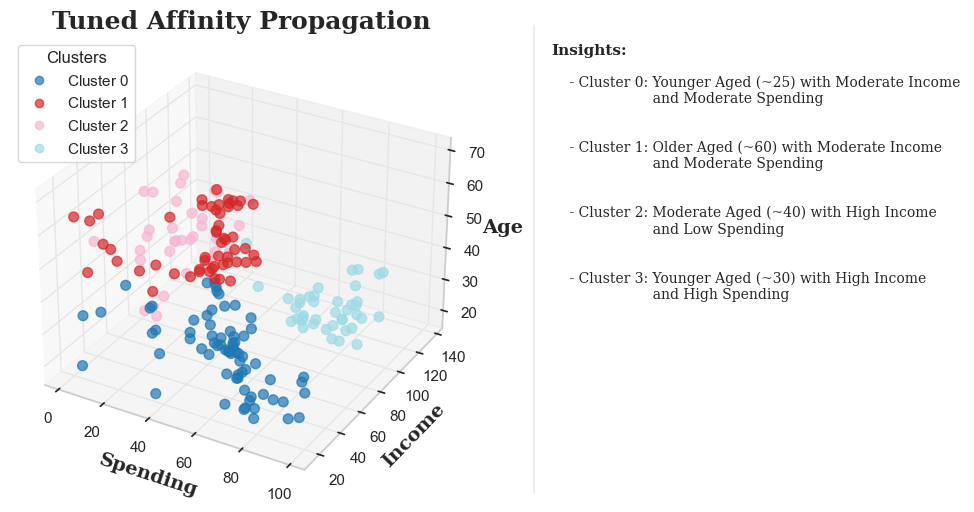

In [52]:
tuned_af = af_grid.best_estimator_

# Fit model to the dataset
tuned_af.fit(X)

# Get the cluster labels
tuned_af_labels = tuned_af.labels_

# Add the cluster labels to a dataframe
tuned_af_df = df.copy()
tuned_af_df['Cluster'] = tuned_af_labels

# Plot 3d scatterplot using matplotlib
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(
    tuned_af_df['Spending'],
    tuned_af_df['Income'],
    tuned_af_df['Age'],
    c=tuned_af_df['Cluster'],
    s=50,
    cmap='tab20',
    alpha=0.7
)

# Add labels
ax.set_xlabel('Spending', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Income', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_zlabel('Age', fontsize=14, fontweight='bold', fontfamily='serif')

# Add title and legend
ax.set_title('Tuned Affinity Propagation', fontsize=18, fontweight='bold', fontfamily='serif')

handles, labels = scatter.legend_elements(prop='colors', alpha=0.7)
labels = list(map(lambda x: 'Cluster ' + x, labels))
legend = ax.legend(handles, labels, loc='upper left', title="Clusters")

l1 = lines.Line2D([1, 1], [0.12, 0.9], transform=fig.transFigure, figure=fig,color='gray',lw=0.2)
fig.lines.extend([l1])

fig.text(
    1.03,
    0.85,
    'Insights:',
    fontsize=11,
    fontweight='bold',
    fontfamily='serif'
)


fig.text(
    1.03,
    0.39,
    '''
    - Cluster 0: Younger Aged (~25) with Moderate Income 
                       and Moderate Spending


    - Cluster 1: Older Aged (~60) with Moderate Income 
                       and Moderate Spending


    - Cluster 2: Moderate Aged (~40) with High Income
                       and Low Spending


    - Cluster 3: Younger Aged (~30) with High Income
                       and High Spending

    ''',
    fontsize=10,
    fontweight='light',
    fontfamily='serif'
)

plt.show()

In [53]:
# Get the summary data for each cluster
tuned_af_df.groupby(by=['Cluster']).mean().round(2)

,Age,Income,Spending
Cluster,,,
0,27.36,41.84,55.04
1,56.22,48.81,42.78
2,41.80,85.83,16.49
3,33.07,86.41,80.49


- Cluster 0: Younger Aged (~25) with Moderate Income 
and Moderate Spending


- Cluster 1: Older Aged (~60) with Moderate Income 
and Moderate Spending


- Cluster 2: Moderate Aged (~40) with High Income
and Low Spending


- Cluster 3: Younger Aged (~30) with High Income
and High Spending

**Observations**:
- From the clusters above, it seems that younger customers (Clusters 0 and 3) seem to have a higher spending regardless of income while Middle-Aged and Older-Aged customers (Clusters 1 and 2) seem to have a lower spending
- It seems that Cluster 3 is the most valuable to the shopping mall due to their high income and high spending
- The shopping mall can also try to target customers in Cluster 2 since they are High Income customers but with Low Spending

**Summary**:

From the intepretation it seems that there are quite a lot of similarities between the clusters from both models. 

Ultimately, the main customer base which is most valuable to the shopping malls are those that are in their 30s with High Income and High Spending Score (Cluster 1  in KMeans, Cluster 3 in Affinity Propagation). Since they are cusomters in their 30s with high income, one way the shopping mall can encourage more spending from this group would be by opening more shops with a focus on luxury brands which would likely fit the interest of this group of customers.

In addition, another similarity are the customers that are in their 40s with high income but significantly lower spending (Cluster 4 in KMeans, Cluster 2 in Affinity Propagation). Given the maturity of this group of customers, the way to try and encourage more spending from them would be by using long term benefits to attract them even if the initial investment is higher. This could be in the form of products or exclusive premium loyalty programs